# 02807 Computational Tools for Data Science - Final Project

Group members:
 - Ana Marija Pavičić (s232468)
 - Anna Sky Kastl Jensen (s194824)
 - Raquel Moleiro Marques (s243636)
 - Sree Keerthi Desu (s243933)

#### Imports

In [2]:
%%capture
!pip install nbimporter
from imports import *

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


# 1. Data pre-processing

In [3]:
# Data paths
raw_data_directory = 'data'
raw_data_path = 'data/product_info.csv'
processed_data_directory = 'processed_data'
processed_data_path = processed_data_directory + '/skincare.csv'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Data Cleaning

In [4]:
# Read all products info
df = pd.read_csv(raw_data_path)

# Filter df for rows where 'primary_category' is 'Skincare'
skincare_df = df[df['primary_category'] == 'Skincare']
print("Skin care data size:", len(skincare_df))

# Remove rows where highlight are non existent
skincare_df = skincare_df[skincare_df['highlights'].notna() & (skincare_df['highlights'] != '')]
print("Skin care data size after removing empty highlights:",len(skincare_df))

# Remove rows where ingredients are non existent
skincare_df = skincare_df[skincare_df['ingredients'].notna() & (skincare_df['ingredients'] != '')]
print("Skin care data size after removing empty ingredients:",len(skincare_df))

# Remove 'Mini' size products from data as it could be seen as a duplicate
skincare_df = skincare_df[~skincare_df['product_name'].str.contains('mini', case=False, na=False)]
# Also removing additional products with 'Mini Size' as their secondary category
skincare_df = skincare_df[skincare_df['secondary_category'] != 'Mini Size']
print(f"Size of skincare data after removing 'mini' from product names (case-insensitive): {len(skincare_df)}")

# Remove 'Limited edition' from data
skincare_df = skincare_df[~skincare_df['product_name'].str.contains('limited edition', case=False, na=False)]
print(f"Size of skincare data after removing 'limited edition' from product names (case-insensitive): {len(skincare_df)}")

# Remove 'Value & Gift Sets' from data to focus on individual products
skincare_df = skincare_df[skincare_df['secondary_category'] != 'Value & Gift Sets']
print("Skin care data size after removing 'Value & Gift Sets' secondary_category:",len(skincare_df))

# Clean highlight column
highlights = skincare_df['highlights']
highlights = [h.replace("[", "").replace("]", "").replace("'", "").replace("Best for ", "").replace("Good for: ", "").replace(" Skin", "").replace("/", ", ") for h in highlights]
skincare_df['highlights'] = highlights

# Function to clean each ingredient row
def clean_ingredients(row):
   # Replace unwanted characters
   row = row.replace("[", "").replace("]", "").replace("'", "").replace(" (Vegan)*", "").replace(".", "")

   # Remove text inside parentheses
   row = re.sub(r'\([^)]*\)', '', row)

   # Replace " , " with a single comma (in case extra spaces after commas)
   row = row.replace(" ,", ",")
   row = row.replace("  ", " ")

   # Check for "water", "aqua", or "eau" and replace first occurrence
   if "water" in row.lower() or "aqua" in row.lower() or "eau" in row.lower():
      row_list = row.split(", ")
      # Find the first occurrence of "water", "aqua", or "eau"
      index = next((i for i, s in enumerate(row_list) if 'water' in s.lower() or "aqua" in s.lower() or "eau" in s.lower()), -1)
      if index != -1:
         # Replace the identified word with "Water"
         row_list[index] = "Water"
      row = ", ".join(row_list)

   return row

# Apply the clean_ingredients function
skincare_df['ingredients'] = skincare_df['ingredients'].apply(clean_ingredients)

# Ensure the directory exists
output_dir = os.path.dirname(processed_data_path)
if not os.path.exists(output_dir):
   os.makedirs(output_dir)

# Save cleaned file
skincare_df.to_csv(processed_data_path, index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Skin care data size: 2420
Skin care data size after removing empty highlights: 2003
Skin care data size after removing empty ingredients: 1927
Size of skincare data after removing 'mini' from product names (case-insensitive): 1743
Size of skincare data after removing 'limited edition' from product names (case-insensitive): 1741
Skin care data size after removing 'Value & Gift Sets' secondary_category: 1583


## Clean and Filter Product Reviews

In [5]:
# Convert product_id column to a set for efficient filtering
product_ids = set(skincare_df['product_id'])

def clean_reviews(raw_data_path, processed_data_path):
    """
    Clean the reviews in the given CSV file by filtering based on the conditions.
    - Filters rows where 'product_id' is in the skincare dataset.
    - Keeps reviews with rating 5, 4, and only 3-star reviews if they have review text.
    """
    try:
        # Read the data
        df = pd.read_csv(raw_data_path)

        # Keep only the filtered skincare data
        df = df[df['product_id'].isin(product_ids)]

        # # Check for 3-star reviews with no text or empty text
        # three_star_reviews = df[df['rating'] == 3]
        # no_text_reviews = three_star_reviews[three_star_reviews['review_text'].isna() | (three_star_reviews['review_text'].str.strip() == '')]

        # Keep reviews with rating 5, 4, or 3 (only keep 3-star reviews if they have review text)
        df = df[
            (df['rating'].isin((5, 4))) |
            ((df['rating'] == 3) & df['review_text'].notna() & (df['review_text'].str.strip() != ""))  # Include 3-star reviews only if they have text
        ]

        # Ensure the output directory exists
        output_dir = os.path.dirname(processed_data_path)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Save the cleaned file
        df.to_csv(processed_data_path, index=False)
        print(f"Processed and saved: {processed_data_path}")

    except Exception as e:
        print(f"Error processing {raw_data_path}: {e}")

# Apply the function to each review data file
clean_reviews('data/reviews_0-250.csv', 'processed_data/reviews_0-250.csv')
clean_reviews('data/reviews_250-500.csv', 'processed_data/reviews_250-500.csv')
clean_reviews('data/reviews_500-750.csv', 'processed_data/reviews_500-750.csv')
clean_reviews('data/reviews_750-1250.csv', 'processed_data/reviews_750-1250.csv')
clean_reviews('data/reviews_1250-end.csv', 'processed_data/reviews_1250-end.csv')

print("All files have been processed and saved.")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<ipython-input-5-07f3132be6bf>:12: DtypeWarning:

Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.



Processed and saved: processed_data/reviews_0-250.csv
Processed and saved: processed_data/reviews_250-500.csv
Processed and saved: processed_data/reviews_500-750.csv


<ipython-input-5-07f3132be6bf>:12: DtypeWarning:

Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.



Processed and saved: processed_data/reviews_750-1250.csv


<ipython-input-5-07f3132be6bf>:12: DtypeWarning:

Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.



Processed and saved: processed_data/reviews_1250-end.csv
All files have been processed and saved.


## Combining All Reviews Files Into a Single Dataframe

In [6]:
# List of file paths for the processed reviews
file_paths = [
    'processed_data/reviews_0-250.csv',
    'processed_data/reviews_250-500.csv',
    'processed_data/reviews_500-750.csv',
    'processed_data/reviews_750-1250.csv',
    'processed_data/reviews_1250-end.csv'
]

# Combine all files into one DataFrame
combined_reviews_df = pd.DataFrame()

for file_path in file_paths:
    try:
        # Read each processed file with updated argument for handling bad lines
        df = pd.read_csv(file_path,
                         on_bad_lines='skip',  # Skip bad lines instead of using deprecated arguments
                         encoding='utf-8',  # Ensure proper encoding
                         engine='python')  # Use Python engine for more robust handling

        # Append it to the combined DataFrame
        combined_reviews_df = pd.concat([combined_reviews_df, df], ignore_index=True)
        print(f"Successfully added {file_path}")
    except Exception as e:
        print(f"Error reading {file_path}: {e}")

# Save the combined DataFrame to a single CSV file
output_combined_path = 'processed_data/combined_reviews.csv'
combined_reviews_df.to_csv(output_combined_path, index=False)
print(f"All files have been combined and saved to: {output_combined_path}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Successfully added processed_data/reviews_0-250.csv
Successfully added processed_data/reviews_250-500.csv
Successfully added processed_data/reviews_500-750.csv
Successfully added processed_data/reviews_750-1250.csv
Successfully added processed_data/reviews_1250-end.csv
All files have been combined and saved to: processed_data/combined_reviews.csv


# 2. Exploratory Data Analysis (EDA)

### Skincare data

In [7]:
# Display the first few rows to get a sense of the data
print("Skincare Data Overview:")
print(skincare_df.head())

Skincare Data Overview:
   product_id                                       product_name  brand_id  \
89    P439055               GENIUS Sleeping Collagen Moisturizer      6018   
90    P421277                       GENIUS Liquid Collagen Serum      6018   
92    P432045               GENIUS Liquid Collagen Lip Treatment      6018   
93    P311143  SUBLIME DEFENSE Ultra Lightweight UV Defense F...      6018   
94    P384537                   GENIUS Ultimate Anti-Aging Cream      6018   

   brand_name  loves_count  rating  reviews           size variation_type  \
89   Algenist        33910  4.5413   1321.0    2 oz/ 60 mL           Size   
90   Algenist        67870  4.0259   1159.0  1 oz  / 30 mL           Size   
92   Algenist        44448  3.8721    649.0  .5 oz / 15 mL           Size   
93   Algenist        27278  4.4134    508.0           1 oz           Size   
94   Algenist        19733  4.2525    503.0    2 oz/ 60 mL           Size   

   variation_value  ... online_only out_of_s

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [8]:
# Get general info
print("\nSkincare Data Info:")
print(skincare_df.info())


Skincare Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1583 entries, 89 to 8423
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_id          1583 non-null   object 
 1   product_name        1583 non-null   object 
 2   brand_id            1583 non-null   int64  
 3   brand_name          1583 non-null   object 
 4   loves_count         1583 non-null   int64  
 5   rating              1550 non-null   float64
 6   reviews             1550 non-null   float64
 7   size                1525 non-null   object 
 8   variation_type      1506 non-null   object 
 9   variation_value     1478 non-null   object 
 10  variation_desc      7 non-null      object 
 11  ingredients         1583 non-null   object 
 12  price_usd           1583 non-null   float64
 13  value_price_usd     17 non-null     float64
 14  sale_price_usd      17 non-null     float64
 15  limited_edition     1583 non-null   in

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [9]:
# Describe numerical columns for basic statistics
print("\nSkincare Data Statistics:")
print(skincare_df.describe())


Skincare Data Statistics:
          brand_id   loves_count       rating       reviews    price_usd  \
count  1583.000000  1.583000e+03  1550.000000   1550.000000  1583.000000   
mean   5676.037903  3.286060e+04     4.291681    529.062581    61.408149   
std    1421.601813  6.625197e+04     0.418085    936.350434    58.640613   
min    1063.000000  0.000000e+00     1.000000      1.000000     3.000000   
25%    5668.000000  4.284000e+03     4.095425     65.000000    30.000000   
50%    6195.000000  1.191200e+04     4.363600    227.500000    46.000000   
75%    6327.000000  3.440700e+04     4.569575    562.000000    71.000000   
max    8017.000000  1.081315e+06     5.000000  16118.000000   495.000000   

       value_price_usd  sale_price_usd  limited_edition          new  \
count        17.000000       17.000000      1583.000000  1583.000000   
mean        199.176471       18.205882         0.007581     0.078964   
std         184.000080       20.898609         0.086763     0.269768   


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



### Product Reviews Data

In [10]:
# Display the first few rows to get a sense of the data
print("\nReview Data Overview:")
print(combined_reviews_df.head())


Review Data Overview:
  Unnamed: 0    author_id  rating  is_recommended helpfulness  \
0          0   1741593524     5.0             1.0         1.0   
1          2   5061282401     5.0             1.0         NaN   
2          3   6083038851     5.0             1.0         NaN   
3          4  47056667835     5.0             1.0         NaN   
4          5  42802569154     4.0             1.0         1.0   

   total_feedback_count total_neg_feedback_count total_pos_feedback_count  \
0                   2.0                        0                        2   
1                   0.0                        0                        0   
2                   0.0                        0                        0   
3                   0.0                        0                        0   
4                   1.0                        0                        1   

  submission_time                                        review_text  \
0      2023-02-01  I use this with the Nudestix “Ci

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [11]:
# Get general info
print("\nReview Data Info:")
print(combined_reviews_df.info())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.




Review Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740390 entries, 0 to 740389
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                740390 non-null  object 
 1   author_id                 740203 non-null  object 
 2   rating                    739955 non-null  float64
 3   is_recommended            633266 non-null  float64
 4   helpfulness               331220 non-null  object 
 5   total_feedback_count      739955 non-null  float64
 6   total_neg_feedback_count  740226 non-null  object 
 7   total_pos_feedback_count  740226 non-null  object 
 8   submission_time           740226 non-null  object 
 9   review_text               739298 non-null  object 
 10  review_title              526191 non-null  object 
 11  skin_tone                 627748 non-null  object 
 12  eye_color                 606040 non-null  object 
 13  skin_type                

In [12]:
# Describe numerical columns for basic statistics
print("\nReview Data Statistics:")
print(combined_reviews_df.describe())


Review Data Statistics:
              rating  is_recommended  total_feedback_count      price_usd
count  739955.000000   633266.000000         739955.000000  739684.000000
mean        4.631782        0.938369              3.436651      52.430729
std         0.629846        0.240485             21.561642      41.600266
min         3.000000        0.000000              0.000000       3.000000
25%         4.000000        1.000000              0.000000      30.000000
50%         5.000000        1.000000              0.000000      44.000000
75%         5.000000        1.000000              3.000000      65.000000
max         5.000000        1.000000           5464.000000     449.000000


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



### Distribution of categorical and numerical features

#### Skincare data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.




Skincare Secondary Categories Distribution:
secondary_category
Moisturizers              432
Treatments                395
Cleansers                 270
Eye Care                  146
Masks                     117
Sunscreen                  80
Lip Balms & Treatments     46
Self Tanners               42
Wellness                   34
High Tech Tools            21
Name: count, dtype: int64


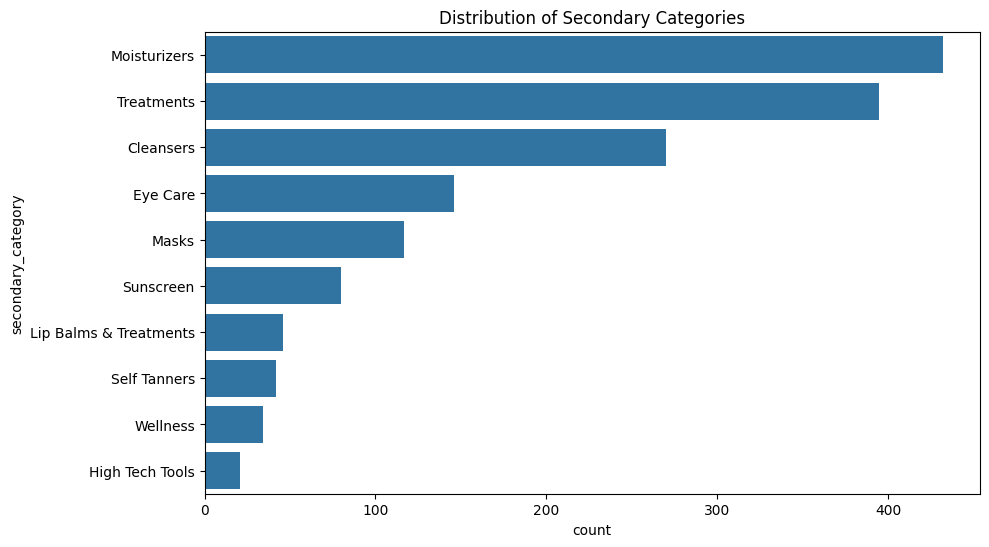

In [13]:
# Check distribution of secondary categories
print("\nSkincare Secondary Categories Distribution:")
secondary_category_counts = skincare_df['secondary_category'].value_counts().sort_values(ascending=False)
print(secondary_category_counts)

# Plot the distribution of secondary categories
plt.figure(figsize=(10,6))
sns.countplot(
    y='secondary_category',
    data=skincare_df,
    order=secondary_category_counts.index  # Sort the plot by frequency
)
plt.title('Distribution of Secondary Categories')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



                Brand  Counts  Percent
0  SEPHORA COLLECTION      56     3.54
1        The Ordinary      39     2.46
2      The INKEY List      37     2.34
3      Paula's Choice      34     2.15
4               fresh      32     2.02
5   Peter Thomas Roth      31     1.96
6   Dr. Barbara Sturm      31     1.96
7            Caudalie      30     1.90
8            Shiseido      30     1.90
9  Kiehl's Since 1851      30     1.90


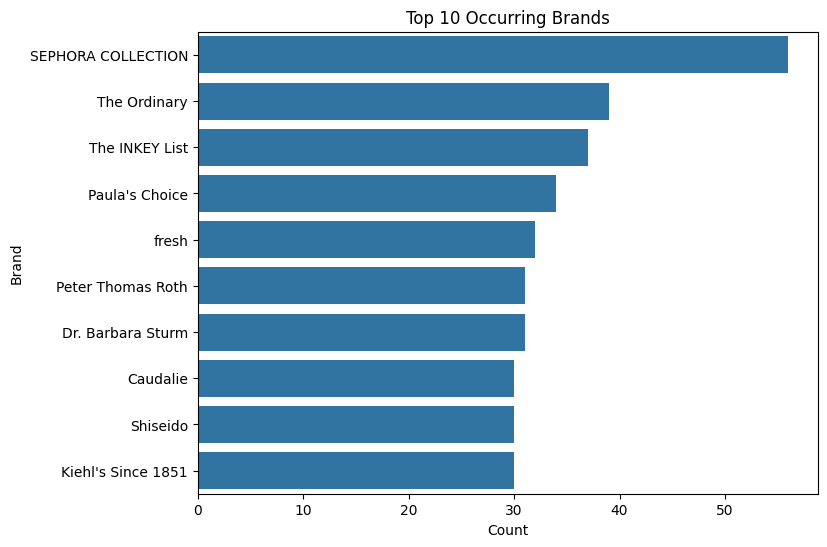

In [14]:
# Get the count and percentage of top brands
brand_count = skincare_df['brand_name'].value_counts()
brand_percentage = skincare_df['brand_name'].value_counts(normalize=True) * 100

# Create a DataFrame for the top brands
brand_df = pd.DataFrame({'Brand': brand_count.index, 'Counts': brand_count.values, 'Percent': np.round(brand_percentage.values, 2)})

# Display the top 10 brands
print(brand_df.head(10))

# Plot the top 10 brands horizontally
plt.figure(figsize=(8, 6))
sns.barplot(x='Counts', y='Brand', data=brand_df.head(10))
plt.xlabel('Count')
plt.title('Top 10 Occurring Brands')
plt.show()

#### Product Reviews Data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.




Review Ratings Distribution:
rating
5.0    528193
4.0    151059
3.0     60703
Name: count, dtype: int64


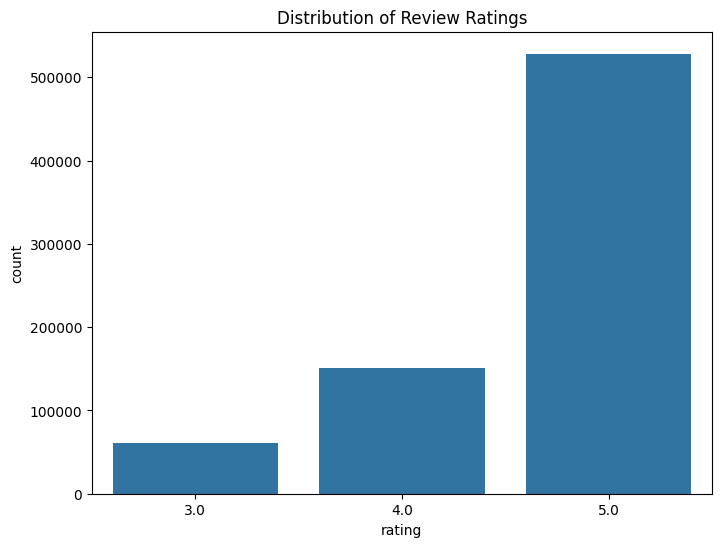

In [15]:
# Review rating distribution
print("\nReview Ratings Distribution:")
print(combined_reviews_df['rating'].value_counts())

# Plot the rating distribution
plt.figure(figsize=(8,6))
sns.countplot(x='rating', data=combined_reviews_df)
plt.title('Distribution of Review Ratings')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



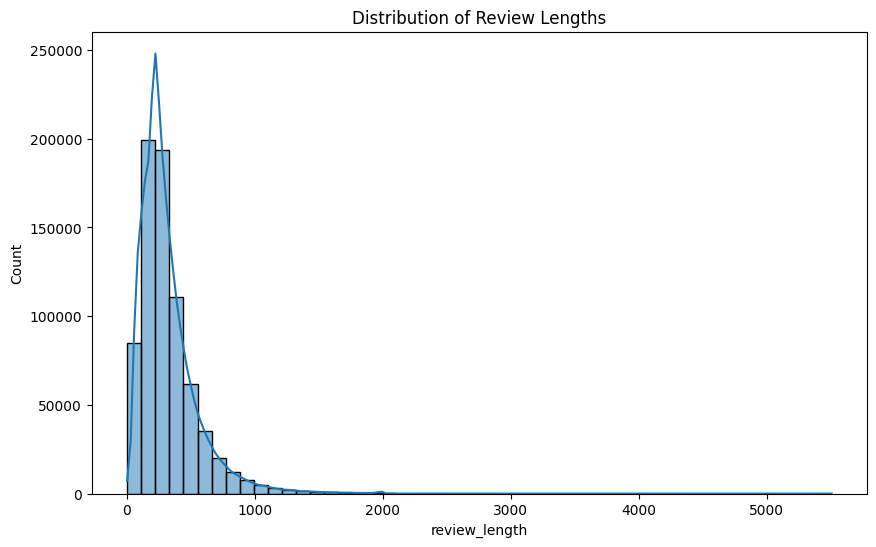

In [16]:
# Review length (characters in review text)
combined_reviews_df['review_length'] = combined_reviews_df['review_text'].apply(lambda x: len(str(x)))

# Plot distribution of review lengths
plt.figure(figsize=(10,6))
sns.histplot(combined_reviews_df['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.show()

___

## Filtering 3-Star Reviews

In [17]:
# Load the combined reviews data from the saved file
combined_reviews_df = pd.read_csv('processed_data/combined_reviews.csv', encoding='utf-8', engine='python')

# Filter for reviews with rating = 3 to perform sentiment analysis on the same
three_stars = combined_reviews_df[combined_reviews_df['rating'] == 3]

print(f"Total reviews with rating of 3: {len(three_stars)}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Total reviews with rating of 3: 60703


## *is_recommended* column in the dataset

To ensure we would recommend products well-regarded by users, we explored the *is_recommended*  column in our reviews dataset and performed a series of checks to evaluate its reliability. As per the following:

In [ ]:
# Count the number of 1s, 0s, and NAs in the 'is_recommended' column for 3-5 stars reviews
is_recommended_counts = combined_reviews_df['is_recommended'].value_counts(dropna=False)
is_recommended_counts

,count
is_recommended,
1.0,594237
NaN,107124
0.0,39029


We can already tell that there are a lot of missing values in the *is_recommended* column. Either way, before proceeding, we’ll check if any 5-star reviews are incorrectly marked as not recommended, as we would expect these to generally be recommended. This will help ensure data quality.

In [ ]:
# Filter 5-star reviews
five_star_reviews = combined_reviews_df[combined_reviews_df['rating'] == 5]

# Check how many of the 5-star reviews are not recommended
not_recommended_5_stars = five_star_reviews[five_star_reviews['is_recommended'] == 0]

# Count the number of 5-star reviews that are not recommended
not_recommended_count = not_recommended_5_stars.shape[0]

print(f"Number of 5-star reviews marked as not recommended: {not_recommended_count}")

# Show a random review_text from the not recommended 5-star reviews, random seed set for reproducibility
random_example = not_recommended_5_stars['review_text'].sample(1, random_state=42).iloc[0]

print("\nRandom example of 5-star review marked as not recommended:")
print(random_example)

Number of 5-star reviews marked as not recommended: 610

Random example of 5-star review marked as not recommended:
This stuff is sooo good. Literally makes your lips feel so soft


Since there are 610 5-star reviews marked as "not recommended," and the random review test shows a very positive review from a happy user, this *is_recommended* column can't be trusted. Therefore, we'll rely on sentiment analysis to accurately identify products users truly recommend and feel good about.

# 3. Sentiment Analysis on Product Reviews

## xlnet-base-cased-product-review-sentiment-analysis

Below we use [xlnet-base-cased-product-review-sentiment-analysis](https://huggingface.co/dipawidia/xlnet-base-cased-product-review-sentiment-analysis)  model from Hugging face to perform sentiment analysis.

In [ ]:
# Initialize the tokenizer and model
tokenizer = XLNetTokenizer.from_pretrained("dipawidia/xlnet-base-cased-product-review-sentiment-analysis")
model = TFXLNetForSequenceClassification.from_pretrained("dipawidia/xlnet-base-cased-product-review-sentiment-analysis")

# Function to analyze sentiment for a batch of reviews
def get_sentiment_batch(reviews_batch):
    tokenize_text = tokenizer(reviews_batch.tolist(), padding=True, truncation=True, return_tensors='tf', max_length=512)
    preds = model.predict(dict(tokenize_text))['logits']
    class_preds = np.argmax(tf.keras.layers.Softmax()(preds), axis=-1)
    labels = ['Positive' if pred == 1 else 'Negative' for pred in class_preds]
    return labels

# Batch size for processing reviews
batch_size = 64

# Initialize the progress bar for batching
num_batches = len(three_stars) // batch_size + (1 if len(three_stars) % batch_size != 0 else 0)

# List to hold sentiment results
sentiment_results = []

# Process reviews in batches
for i in tqdm(range(0, len(three_stars), batch_size), total=num_batches, desc="Processing reviews", unit="batch"):
    batch = three_stars['review_text'][i:i + batch_size]  # Get the current batch of reviews
    batch_sentiments = get_sentiment_batch(batch)  # Get sentiments for the current batch
    sentiment_results.extend(batch_sentiments)  # Append results

# Assign the sentiment results back to the dataframe
three_stars['sentiment'] = sentiment_results

# Count positive and negative sentiments
sentiment_counts = three_stars['sentiment'].value_counts()
print(sentiment_counts)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/469M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
All PyTorch model weights were used when initializing TFXLNetForSequenceClassification.

All the weights of TFXLNetForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetForSequenceClassification for predictions without further training.
Processing reviews:   0%|          | 0/949 [00:00<?, ?batch/s]

2/2 [==============================] - 9s 63ms/step


Processing reviews:   0%|          | 1/949 [00:10<2:44:59, 10.44s/batch]

2/2 [==============================] - 5s 529ms/step


Processing reviews:   0%|          | 2/949 [00:16<2:03:11,  7.80s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:   0%|          | 3/949 [00:21<1:43:13,  6.55s/batch]

2/2 [==============================] - 1s 522ms/step


Processing reviews:   0%|          | 4/949 [00:24<1:19:01,  5.02s/batch]

2/2 [==============================] - 2s 774ms/step


Processing reviews:   1%|          | 5/949 [00:26<1:04:25,  4.09s/batch]

2/2 [==============================] - 2s 933ms/step


Processing reviews:   1%|          | 6/949 [00:29<58:14,  3.71s/batch]  

2/2 [==============================] - 2s 878ms/step


Processing reviews:   1%|          | 7/949 [00:32<53:20,  3.40s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:   1%|          | 8/949 [00:37<1:02:41,  4.00s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:   1%|          | 9/949 [00:42<1:09:09,  4.41s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:   1%|          | 10/949 [00:46<1:06:30,  4.25s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:   1%|          | 11/949 [00:57<1:35:57,  6.14s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:   1%|▏         | 12/949 [01:01<1:25:02,  5.45s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:   1%|▏         | 13/949 [01:04<1:14:56,  4.80s/batch]

2/2 [==============================] - 2s 777ms/step


Processing reviews:   1%|▏         | 14/949 [01:06<1:02:58,  4.04s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:   2%|▏         | 15/949 [01:11<1:08:36,  4.41s/batch]

2/2 [==============================] - 1s 472ms/step


Processing reviews:   2%|▏         | 16/949 [01:13<55:26,  3.56s/batch]  

2/2 [==============================] - 2s 795ms/step


Processing reviews:   2%|▏         | 17/949 [01:16<51:20,  3.31s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:   2%|▏         | 18/949 [01:19<51:25,  3.31s/batch]

2/2 [==============================] - 2s 817ms/step


Processing reviews:   2%|▏         | 19/949 [01:22<48:34,  3.13s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:   2%|▏         | 20/949 [01:25<49:45,  3.21s/batch]

2/2 [==============================] - 1s 594ms/step


Processing reviews:   2%|▏         | 21/949 [01:28<47:14,  3.05s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:   2%|▏         | 22/949 [01:33<58:44,  3.80s/batch]

2/2 [==============================] - 1s 723ms/step


Processing reviews:   2%|▏         | 23/949 [01:36<53:36,  3.47s/batch]

2/2 [==============================] - 1s 617ms/step


Processing reviews:   3%|▎         | 24/949 [01:39<50:05,  3.25s/batch]

2/2 [==============================] - 2s 793ms/step


Processing reviews:   3%|▎         | 25/949 [01:41<45:38,  2.96s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:   3%|▎         | 26/949 [01:44<45:46,  2.98s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:   3%|▎         | 27/949 [01:48<50:03,  3.26s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:   3%|▎         | 28/949 [01:51<48:59,  3.19s/batch]

2/2 [==============================] - 2s 906ms/step


Processing reviews:   3%|▎         | 29/949 [01:54<47:01,  3.07s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:   3%|▎         | 30/949 [01:57<47:36,  3.11s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:   3%|▎         | 31/949 [02:01<52:50,  3.45s/batch]

2/2 [==============================] - 2s 931ms/step


Processing reviews:   3%|▎         | 32/949 [02:07<1:01:01,  3.99s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:   3%|▎         | 33/949 [02:12<1:06:51,  4.38s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:   4%|▎         | 34/949 [02:17<1:10:56,  4.65s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:   4%|▎         | 35/949 [02:22<1:13:51,  4.85s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:   4%|▍         | 36/949 [02:27<1:11:37,  4.71s/batch]

2/2 [==============================] - 1s 407ms/step


Processing reviews:   4%|▍         | 37/949 [02:28<56:22,  3.71s/batch]  

2/2 [==============================] - 6s 3s/step


Processing reviews:   4%|▍         | 38/949 [02:36<1:13:42,  4.86s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:   4%|▍         | 39/949 [02:41<1:16:16,  5.03s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:   4%|▍         | 40/949 [02:46<1:17:25,  5.11s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:   4%|▍         | 41/949 [02:52<1:18:19,  5.18s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:   4%|▍         | 42/949 [02:55<1:09:24,  4.59s/batch]

2/2 [==============================] - 2s 863ms/step


Processing reviews:   5%|▍         | 43/949 [02:58<1:00:40,  4.02s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:   5%|▍         | 44/949 [03:03<1:06:15,  4.39s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:   5%|▍         | 45/949 [03:08<1:10:11,  4.66s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:   5%|▍         | 46/949 [03:19<1:36:05,  6.38s/batch]

2/2 [==============================] - 2s 751ms/step


Processing reviews:   5%|▍         | 47/949 [03:21<1:17:16,  5.14s/batch]

2/2 [==============================] - 2s 956ms/step


Processing reviews:   5%|▌         | 48/949 [03:24<1:06:24,  4.42s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:   5%|▌         | 49/949 [03:29<1:10:11,  4.68s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:   5%|▌         | 50/949 [03:33<1:08:18,  4.56s/batch]

2/2 [==============================] - 2s 964ms/step


Processing reviews:   5%|▌         | 51/949 [03:38<1:11:20,  4.77s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:   5%|▌         | 52/949 [03:44<1:13:27,  4.91s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:   6%|▌         | 53/949 [03:49<1:14:57,  5.02s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:   6%|▌         | 54/949 [03:52<1:05:35,  4.40s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:   6%|▌         | 55/949 [03:57<1:09:31,  4.67s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:   6%|▌         | 56/949 [04:03<1:12:21,  4.86s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:   6%|▌         | 57/949 [04:08<1:14:13,  4.99s/batch]

2/2 [==============================] - 1s 699ms/step


Processing reviews:   6%|▌         | 58/949 [04:11<1:04:11,  4.32s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:   6%|▌         | 59/949 [04:14<1:01:25,  4.14s/batch]

2/2 [==============================] - 1s 711ms/step


Processing reviews:   6%|▋         | 60/949 [04:17<54:57,  3.71s/batch]  

2/2 [==============================] - 2s 1s/step


Processing reviews:   6%|▋         | 61/949 [04:22<1:01:57,  4.19s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:   7%|▋         | 62/949 [04:30<1:17:45,  5.26s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:   7%|▋         | 63/949 [04:35<1:17:56,  5.28s/batch]

2/2 [==============================] - 1s 696ms/step


Processing reviews:   7%|▋         | 64/949 [04:38<1:06:47,  4.53s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:   7%|▋         | 65/949 [04:43<1:07:52,  4.61s/batch]

2/2 [==============================] - 5s 2s/step


Processing reviews:   7%|▋         | 66/949 [04:53<1:33:20,  6.34s/batch]

2/2 [==============================] - 1s 670ms/step


Processing reviews:   7%|▋         | 67/949 [04:56<1:17:03,  5.24s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:   7%|▋         | 68/949 [05:01<1:17:03,  5.25s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:   7%|▋         | 69/949 [05:07<1:17:03,  5.25s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:   7%|▋         | 70/949 [05:11<1:15:15,  5.14s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:   7%|▋         | 71/949 [05:17<1:15:56,  5.19s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:   8%|▊         | 72/949 [05:22<1:18:07,  5.35s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:   8%|▊         | 73/949 [05:30<1:29:18,  6.12s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:   8%|▊         | 74/949 [05:36<1:25:44,  5.88s/batch]

2/2 [==============================] - 5s 2s/step


Processing reviews:   8%|▊         | 75/949 [05:46<1:45:37,  7.25s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:   8%|▊         | 76/949 [05:50<1:29:09,  6.13s/batch]

2/2 [==============================] - 2s 971ms/step


Processing reviews:   8%|▊         | 77/949 [05:52<1:14:25,  5.12s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:   8%|▊         | 78/949 [06:03<1:37:24,  6.71s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:   8%|▊         | 79/949 [06:08<1:28:21,  6.09s/batch]

2/2 [==============================] - 5s 2s/step


Processing reviews:   8%|▊         | 80/949 [06:18<1:47:01,  7.39s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:   9%|▊         | 81/949 [06:28<1:59:54,  8.29s/batch]

2/2 [==============================] - 2s 973ms/step


Processing reviews:   9%|▊         | 82/949 [06:34<1:46:39,  7.38s/batch]

2/2 [==============================] - 5s 3s/step


Processing reviews:   9%|▊         | 83/949 [06:41<1:45:21,  7.30s/batch]

2/2 [==============================] - 5s 2s/step


Processing reviews:   9%|▉         | 84/949 [06:47<1:40:10,  6.95s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:   9%|▉         | 85/949 [06:53<1:34:49,  6.59s/batch]

2/2 [==============================] - 2s 823ms/step


Processing reviews:   9%|▉         | 86/949 [06:55<1:18:17,  5.44s/batch]

2/2 [==============================] - 2s 977ms/step


Processing reviews:   9%|▉         | 87/949 [07:01<1:17:37,  5.40s/batch]

2/2 [==============================] - 1s 794ms/step


Processing reviews:   9%|▉         | 88/949 [07:03<1:04:18,  4.48s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:   9%|▉         | 89/949 [07:13<1:29:42,  6.26s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:   9%|▉         | 90/949 [07:19<1:25:16,  5.96s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  10%|▉         | 91/949 [07:22<1:13:09,  5.12s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  10%|▉         | 92/949 [07:26<1:09:13,  4.85s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  10%|▉         | 93/949 [07:37<1:33:21,  6.54s/batch]

2/2 [==============================] - 2s 938ms/step


Processing reviews:  10%|▉         | 94/949 [07:39<1:17:10,  5.42s/batch]

2/2 [==============================] - 1s 624ms/step


Processing reviews:  10%|█         | 95/949 [07:42<1:05:24,  4.60s/batch]

2/2 [==============================] - 2s 853ms/step


Processing reviews:  10%|█         | 96/949 [07:45<57:09,  4.02s/batch]  

2/2 [==============================] - 2s 854ms/step


Processing reviews:  10%|█         | 97/949 [07:47<50:18,  3.54s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  10%|█         | 98/949 [07:50<49:36,  3.50s/batch]

2/2 [==============================] - 5s 2s/step


Processing reviews:  10%|█         | 99/949 [08:01<1:19:10,  5.59s/batch]

2/2 [==============================] - 1s 594ms/step


Processing reviews:  11%|█         | 100/949 [08:04<1:06:47,  4.72s/batch]

2/2 [==============================] - 2s 925ms/step


Processing reviews:  11%|█         | 101/949 [08:06<58:46,  4.16s/batch]  

2/2 [==============================] - 5s 3s/step


Processing reviews:  11%|█         | 102/949 [08:17<1:25:23,  6.05s/batch]

2/2 [==============================] - 2s 839ms/step


Processing reviews:  11%|█         | 103/949 [08:20<1:11:17,  5.06s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  11%|█         | 104/949 [08:25<1:12:22,  5.14s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  11%|█         | 105/949 [08:29<1:05:21,  4.65s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  11%|█         | 106/949 [08:34<1:08:02,  4.84s/batch]

2/2 [==============================] - 2s 850ms/step


Processing reviews:  11%|█▏        | 107/949 [08:37<59:08,  4.21s/batch]  

2/2 [==============================] - 6s 3s/step


Processing reviews:  11%|█▏        | 108/949 [08:47<1:25:25,  6.09s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  11%|█▏        | 109/949 [08:52<1:22:11,  5.87s/batch]

2/2 [==============================] - 1s 485ms/step


Processing reviews:  12%|█▏        | 110/949 [08:54<1:04:10,  4.59s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  12%|█▏        | 111/949 [08:59<1:07:06,  4.80s/batch]

2/2 [==============================] - 2s 816ms/step


Processing reviews:  12%|█▏        | 112/949 [09:02<58:22,  4.18s/batch]  

2/2 [==============================] - 2s 1s/step


Processing reviews:  12%|█▏        | 113/949 [09:07<1:02:46,  4.51s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  12%|█▏        | 114/949 [09:18<1:27:21,  6.28s/batch]

2/2 [==============================] - 1s 689ms/step


Processing reviews:  12%|█▏        | 115/949 [09:20<1:12:13,  5.20s/batch]

2/2 [==============================] - 1s 620ms/step


Processing reviews:  12%|█▏        | 116/949 [09:23<1:01:38,  4.44s/batch]

2/2 [==============================] - 1s 307ms/step


Processing reviews:  12%|█▏        | 117/949 [09:24<47:22,  3.42s/batch]  

2/2 [==============================] - 1s 744ms/step


Processing reviews:  12%|█▏        | 118/949 [09:27<44:22,  3.20s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  13%|█▎        | 119/949 [09:32<53:04,  3.84s/batch]

2/2 [==============================] - 2s 895ms/step


Processing reviews:  13%|█▎        | 120/949 [09:35<47:54,  3.47s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  13%|█▎        | 121/949 [09:40<55:26,  4.02s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  13%|█▎        | 122/949 [09:45<1:00:44,  4.41s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  13%|█▎        | 123/949 [09:48<55:29,  4.03s/batch]  

2/2 [==============================] - 1s 709ms/step


Processing reviews:  13%|█▎        | 124/949 [09:51<47:14,  3.44s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  13%|█▎        | 125/949 [09:56<54:51,  3.99s/batch]

2/2 [==============================] - 2s 827ms/step


Processing reviews:  13%|█▎        | 126/949 [09:58<48:35,  3.54s/batch]

2/2 [==============================] - 1s 739ms/step


Processing reviews:  13%|█▎        | 127/949 [10:01<45:00,  3.29s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  13%|█▎        | 128/949 [10:05<48:39,  3.56s/batch]

2/2 [==============================] - 1s 714ms/step


Processing reviews:  14%|█▎        | 129/949 [10:08<45:07,  3.30s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  14%|█▎        | 130/949 [10:12<46:54,  3.44s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  14%|█▍        | 131/949 [10:17<54:17,  3.98s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  14%|█▍        | 132/949 [10:27<1:20:25,  5.91s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  14%|█▍        | 133/949 [10:33<1:17:41,  5.71s/batch]

2/2 [==============================] - 2s 977ms/step


Processing reviews:  14%|█▍        | 134/949 [10:38<1:15:48,  5.58s/batch]

2/2 [==============================] - 1s 652ms/step


Processing reviews:  14%|█▍        | 135/949 [10:40<1:01:25,  4.53s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  14%|█▍        | 136/949 [10:45<1:04:24,  4.75s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  14%|█▍        | 137/949 [10:50<1:06:33,  4.92s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  15%|█▍        | 138/949 [10:56<1:08:09,  5.04s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  15%|█▍        | 139/949 [11:06<1:29:48,  6.65s/batch]

2/2 [==============================] - 2s 864ms/step


Processing reviews:  15%|█▍        | 140/949 [11:09<1:13:42,  5.47s/batch]

2/2 [==============================] - 1s 677ms/step


Processing reviews:  15%|█▍        | 141/949 [11:12<1:02:26,  4.64s/batch]

2/2 [==============================] - 5s 2s/step


Processing reviews:  15%|█▍        | 142/949 [11:22<1:25:36,  6.37s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  15%|█▌        | 143/949 [11:27<1:21:00,  6.03s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  15%|█▌        | 144/949 [11:33<1:18:03,  5.82s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  15%|█▌        | 145/949 [11:36<1:06:37,  4.97s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  15%|█▌        | 146/949 [11:41<1:07:45,  5.06s/batch]

2/2 [==============================] - 2s 974ms/step


Processing reviews:  15%|█▌        | 147/949 [11:46<1:08:32,  5.13s/batch]

2/2 [==============================] - 2s 890ms/step


Processing reviews:  16%|█▌        | 148/949 [11:49<58:54,  4.41s/batch]  

2/2 [==============================] - 2s 1s/step


Processing reviews:  16%|█▌        | 149/949 [11:52<53:51,  4.04s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  16%|█▌        | 150/949 [11:57<58:55,  4.42s/batch]

2/2 [==============================] - 2s 815ms/step


Processing reviews:  16%|█▌        | 151/949 [12:00<51:37,  3.88s/batch]

2/2 [==============================] - 2s 842ms/step


Processing reviews:  16%|█▌        | 152/949 [12:03<47:01,  3.54s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  16%|█▌        | 153/949 [12:06<47:37,  3.59s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  16%|█▌        | 154/949 [12:17<1:14:41,  5.64s/batch]

2/2 [==============================] - 2s 764ms/step


Processing reviews:  16%|█▋        | 155/949 [12:19<1:01:10,  4.62s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  16%|█▋        | 156/949 [12:24<1:03:36,  4.81s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  17%|█▋        | 157/949 [12:28<57:35,  4.36s/batch]  

2/2 [==============================] - 2s 817ms/step


Processing reviews:  17%|█▋        | 158/949 [12:30<51:07,  3.88s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  17%|█▋        | 159/949 [12:36<56:26,  4.29s/batch]

2/2 [==============================] - 5s 3s/step


Processing reviews:  17%|█▋        | 160/949 [12:46<1:20:27,  6.12s/batch]

2/2 [==============================] - 2s 871ms/step


Processing reviews:  17%|█▋        | 161/949 [12:49<1:06:24,  5.06s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  17%|█▋        | 162/949 [12:52<58:44,  4.48s/batch]  

2/2 [==============================] - 3s 1s/step


Processing reviews:  17%|█▋        | 163/949 [12:57<1:01:52,  4.72s/batch]

2/2 [==============================] - 2s 945ms/step


Processing reviews:  17%|█▋        | 164/949 [13:00<54:06,  4.14s/batch]  

2/2 [==============================] - 3s 1s/step


Processing reviews:  17%|█▋        | 165/949 [13:05<58:30,  4.48s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  17%|█▋        | 166/949 [13:10<1:01:38,  4.72s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  18%|█▊        | 167/949 [13:16<1:03:56,  4.91s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  18%|█▊        | 168/949 [13:19<56:10,  4.32s/batch]  

2/2 [==============================] - 3s 1s/step


Processing reviews:  18%|█▊        | 169/949 [13:24<59:57,  4.61s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  18%|█▊        | 170/949 [13:28<56:02,  4.32s/batch]

2/2 [==============================] - 2s 918ms/step


Processing reviews:  18%|█▊        | 171/949 [13:30<49:38,  3.83s/batch]

2/2 [==============================] - 5s 3s/step


Processing reviews:  18%|█▊        | 172/949 [13:37<1:01:53,  4.78s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  18%|█▊        | 173/949 [13:43<1:04:33,  4.99s/batch]

2/2 [==============================] - 2s 803ms/step


Processing reviews:  18%|█▊        | 174/949 [13:45<55:31,  4.30s/batch]  

2/2 [==============================] - 3s 1s/step


Processing reviews:  18%|█▊        | 175/949 [13:51<59:19,  4.60s/batch]

2/2 [==============================] - 2s 855ms/step


Processing reviews:  19%|█▊        | 176/949 [13:53<51:36,  4.01s/batch]

2/2 [==============================] - 2s 833ms/step


Processing reviews:  19%|█▊        | 177/949 [13:56<46:26,  3.61s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  19%|█▉        | 178/949 [14:01<52:44,  4.10s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  19%|█▉        | 179/949 [14:04<48:49,  3.80s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  19%|█▉        | 180/949 [14:08<48:13,  3.76s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  19%|█▉        | 181/949 [14:13<53:52,  4.21s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  19%|█▉        | 182/949 [14:19<57:57,  4.53s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  19%|█▉        | 183/949 [14:22<54:53,  4.30s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  19%|█▉        | 184/949 [14:28<58:31,  4.59s/batch]

2/2 [==============================] - 2s 806ms/step


Processing reviews:  19%|█▉        | 185/949 [14:30<51:15,  4.03s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  20%|█▉        | 186/949 [14:36<56:08,  4.42s/batch]

2/2 [==============================] - 2s 783ms/step


Processing reviews:  20%|█▉        | 187/949 [14:38<47:40,  3.75s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  20%|█▉        | 188/949 [14:43<53:19,  4.20s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  20%|█▉        | 189/949 [14:49<58:11,  4.59s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  20%|██        | 190/949 [14:59<1:20:31,  6.37s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  20%|██        | 191/949 [15:04<1:16:28,  6.05s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  20%|██        | 192/949 [15:10<1:13:22,  5.82s/batch]

2/2 [==============================] - 1s 557ms/step


Processing reviews:  20%|██        | 193/949 [15:12<1:01:28,  4.88s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  20%|██        | 194/949 [15:16<57:25,  4.56s/batch]  

2/2 [==============================] - 6s 3s/step


Processing reviews:  21%|██        | 195/949 [15:24<1:08:58,  5.49s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  21%|██        | 196/949 [15:31<1:14:33,  5.94s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  21%|██        | 197/949 [15:36<1:11:56,  5.74s/batch]

2/2 [==============================] - 2s 815ms/step


Processing reviews:  21%|██        | 198/949 [15:39<59:13,  4.73s/batch]  

2/2 [==============================] - 1s 652ms/step


Processing reviews:  21%|██        | 199/949 [15:41<51:32,  4.12s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  21%|██        | 200/949 [15:46<53:36,  4.29s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  21%|██        | 201/949 [15:51<57:06,  4.58s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  21%|██▏       | 202/949 [15:56<59:38,  4.79s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  21%|██▏       | 203/949 [16:02<1:01:31,  4.95s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  21%|██▏       | 204/949 [16:09<1:11:37,  5.77s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  22%|██▏       | 205/949 [16:20<1:29:02,  7.18s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  22%|██▏       | 206/949 [16:25<1:21:56,  6.62s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  22%|██▏       | 207/949 [16:29<1:11:53,  5.81s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  22%|██▏       | 208/949 [16:34<1:09:48,  5.65s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  22%|██▏       | 209/949 [16:40<1:07:47,  5.50s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  22%|██▏       | 210/949 [16:45<1:07:05,  5.45s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  22%|██▏       | 211/949 [16:49<1:00:27,  4.92s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  22%|██▏       | 212/949 [16:52<55:47,  4.54s/batch]  

2/2 [==============================] - 5s 3s/step


Processing reviews:  22%|██▏       | 213/949 [17:03<1:17:35,  6.33s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  23%|██▎       | 214/949 [17:13<1:32:25,  7.55s/batch]

2/2 [==============================] - 2s 916ms/step


Processing reviews:  23%|██▎       | 215/949 [17:16<1:14:27,  6.09s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  23%|██▎       | 216/949 [17:21<1:11:37,  5.86s/batch]

2/2 [==============================] - 5s 3s/step


Processing reviews:  23%|██▎       | 217/949 [17:32<1:28:25,  7.25s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  23%|██▎       | 218/949 [17:42<1:39:53,  8.20s/batch]

2/2 [==============================] - 2s 850ms/step


Processing reviews:  23%|██▎       | 219/949 [17:45<1:18:51,  6.48s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  23%|██▎       | 220/949 [17:55<1:33:04,  7.66s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  23%|██▎       | 221/949 [17:59<1:20:29,  6.63s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  23%|██▎       | 222/949 [18:05<1:15:37,  6.24s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  23%|██▎       | 223/949 [18:15<1:30:48,  7.51s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  24%|██▎       | 224/949 [18:18<1:12:36,  6.01s/batch]

2/2 [==============================] - 1s 571ms/step


Processing reviews:  24%|██▎       | 225/949 [18:19<57:06,  4.73s/batch]  

2/2 [==============================] - 2s 950ms/step


Processing reviews:  24%|██▍       | 226/949 [18:25<58:51,  4.88s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  24%|██▍       | 227/949 [18:28<55:02,  4.57s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  24%|██▍       | 228/949 [18:34<57:26,  4.78s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  24%|██▍       | 229/949 [18:39<59:06,  4.93s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  24%|██▍       | 230/949 [18:44<1:00:25,  5.04s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  24%|██▍       | 231/949 [18:50<1:01:26,  5.13s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  24%|██▍       | 232/949 [18:55<1:01:49,  5.17s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  25%|██▍       | 233/949 [19:02<1:09:34,  5.83s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  25%|██▍       | 234/949 [19:07<1:07:26,  5.66s/batch]

2/2 [==============================] - 2s 960ms/step


Processing reviews:  25%|██▍       | 235/949 [19:13<1:06:03,  5.55s/batch]

2/2 [==============================] - 2s 975ms/step


Processing reviews:  25%|██▍       | 236/949 [19:16<56:24,  4.75s/batch]  

2/2 [==============================] - 2s 1s/step


Processing reviews:  25%|██▍       | 237/949 [19:19<50:56,  4.29s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  25%|██▌       | 238/949 [19:23<48:41,  4.11s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  25%|██▌       | 239/949 [19:28<52:41,  4.45s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  25%|██▌       | 240/949 [19:33<56:22,  4.77s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  25%|██▌       | 241/949 [19:39<58:06,  4.92s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  26%|██▌       | 242/949 [19:43<57:41,  4.90s/batch]

2/2 [==============================] - 5s 3s/step


Processing reviews:  26%|██▌       | 243/949 [19:54<1:17:15,  6.57s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  26%|██▌       | 244/949 [19:59<1:12:56,  6.21s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  26%|██▌       | 245/949 [20:05<1:09:40,  5.94s/batch]

2/2 [==============================] - 2s 921ms/step


Processing reviews:  26%|██▌       | 246/949 [20:07<58:50,  5.02s/batch]  

2/2 [==============================] - 4s 2s/step


Processing reviews:  26%|██▌       | 247/949 [20:13<59:53,  5.12s/batch]

2/2 [==============================] - 2s 822ms/step


Processing reviews:  26%|██▌       | 248/949 [20:15<50:02,  4.28s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  26%|██▌       | 249/949 [20:18<46:33,  3.99s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  26%|██▋       | 250/949 [20:26<59:20,  5.09s/batch]

2/2 [==============================] - 5s 3s/step


Processing reviews:  26%|██▋       | 251/949 [20:36<1:17:45,  6.68s/batch]

2/2 [==============================] - 1s 693ms/step


Processing reviews:  27%|██▋       | 252/949 [20:39<1:01:42,  5.31s/batch]

2/2 [==============================] - 1s 725ms/step


Processing reviews:  27%|██▋       | 253/949 [20:41<52:25,  4.52s/batch]  

2/2 [==============================] - 2s 1s/step


Processing reviews:  27%|██▋       | 254/949 [20:47<55:01,  4.75s/batch]

2/2 [==============================] - 1s 646ms/step


Processing reviews:  27%|██▋       | 255/949 [20:49<46:14,  4.00s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  27%|██▋       | 256/949 [20:52<43:17,  3.75s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  27%|██▋       | 257/949 [21:02<1:06:28,  5.76s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  27%|██▋       | 258/949 [21:07<1:02:36,  5.44s/batch]

2/2 [==============================] - 1s 724ms/step


Processing reviews:  27%|██▋       | 259/949 [21:10<53:01,  4.61s/batch]  

2/2 [==============================] - 1s 741ms/step


Processing reviews:  27%|██▋       | 260/949 [21:12<46:18,  4.03s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  28%|██▊       | 261/949 [21:16<44:07,  3.85s/batch]

2/2 [==============================] - 1s 460ms/step


Processing reviews:  28%|██▊       | 262/949 [21:17<35:57,  3.14s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  28%|██▊       | 263/949 [21:23<43:11,  3.78s/batch]

2/2 [==============================] - 2s 819ms/step


Processing reviews:  28%|██▊       | 264/949 [21:25<38:25,  3.36s/batch]

2/2 [==============================] - 2s 994ms/step


Processing reviews:  28%|██▊       | 265/949 [21:30<44:45,  3.93s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  28%|██▊       | 266/949 [21:36<49:13,  4.33s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  28%|██▊       | 267/949 [21:39<46:21,  4.08s/batch]

2/2 [==============================] - 1s 630ms/step


Processing reviews:  28%|██▊       | 268/949 [21:42<41:35,  3.66s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  28%|██▊       | 269/949 [21:47<47:55,  4.23s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  28%|██▊       | 270/949 [21:51<44:40,  3.95s/batch]

2/2 [==============================] - 2s 808ms/step


Processing reviews:  29%|██▊       | 271/949 [21:53<40:18,  3.57s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  29%|██▊       | 272/949 [21:58<45:56,  4.07s/batch]

2/2 [==============================] - 5s 3s/step


Processing reviews:  29%|██▉       | 273/949 [22:09<1:07:31,  5.99s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  29%|██▉       | 274/949 [22:16<1:11:34,  6.36s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  29%|██▉       | 275/949 [22:22<1:07:54,  6.05s/batch]

2/2 [==============================] - 5s 2s/step


Processing reviews:  29%|██▉       | 276/949 [22:32<1:22:41,  7.37s/batch]

2/2 [==============================] - 5s 2s/step


Processing reviews:  29%|██▉       | 277/949 [22:42<1:32:42,  8.28s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  29%|██▉       | 278/949 [22:46<1:15:39,  6.76s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  29%|██▉       | 279/949 [22:51<1:10:42,  6.33s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  30%|██▉       | 280/949 [22:56<1:07:15,  6.03s/batch]

2/2 [==============================] - 2s 801ms/step


Processing reviews:  30%|██▉       | 281/949 [22:59<55:56,  5.03s/batch]  

2/2 [==============================] - 2s 776ms/step


Processing reviews:  30%|██▉       | 282/949 [23:02<48:02,  4.32s/batch]

2/2 [==============================] - 2s 822ms/step


Processing reviews:  30%|██▉       | 283/949 [23:04<41:29,  3.74s/batch]

2/2 [==============================] - 2s 952ms/step


Processing reviews:  30%|██▉       | 284/949 [23:09<46:37,  4.21s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  30%|███       | 285/949 [23:20<1:07:21,  6.09s/batch]

2/2 [==============================] - 2s 941ms/step


Processing reviews:  30%|███       | 286/949 [23:23<56:25,  5.11s/batch]  

2/2 [==============================] - 3s 1s/step


Processing reviews:  30%|███       | 287/949 [23:28<56:53,  5.16s/batch]

2/2 [==============================] - 2s 737ms/step


Processing reviews:  30%|███       | 288/949 [23:30<47:04,  4.27s/batch]

2/2 [==============================] - 1s 714ms/step


Processing reviews:  30%|███       | 289/949 [23:33<41:50,  3.80s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  31%|███       | 290/949 [23:38<46:42,  4.25s/batch]

2/2 [==============================] - 2s 746ms/step


Processing reviews:  31%|███       | 291/949 [23:40<39:57,  3.64s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  31%|███       | 292/949 [23:46<45:20,  4.14s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  31%|███       | 293/949 [23:48<40:41,  3.72s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  31%|███       | 294/949 [23:54<45:41,  4.19s/batch]

2/2 [==============================] - 2s 819ms/step


Processing reviews:  31%|███       | 295/949 [23:56<40:41,  3.73s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  31%|███       | 296/949 [24:02<45:48,  4.21s/batch]

2/2 [==============================] - 2s 945ms/step


Processing reviews:  31%|███▏      | 297/949 [24:04<40:59,  3.77s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  31%|███▏      | 298/949 [24:07<38:09,  3.52s/batch]

2/2 [==============================] - 1s 739ms/step


Processing reviews:  32%|███▏      | 299/949 [24:09<33:37,  3.10s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  32%|███▏      | 300/949 [24:15<40:38,  3.76s/batch]

2/2 [==============================] - 2s 732ms/step


Processing reviews:  32%|███▏      | 301/949 [24:17<35:44,  3.31s/batch]

2/2 [==============================] - 2s 820ms/step


Processing reviews:  32%|███▏      | 302/949 [24:19<32:29,  3.01s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  32%|███▏      | 303/949 [24:25<39:47,  3.70s/batch]

2/2 [==============================] - 2s 885ms/step


Processing reviews:  32%|███▏      | 304/949 [24:30<44:58,  4.18s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  32%|███▏      | 305/949 [24:35<48:21,  4.51s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  32%|███▏      | 306/949 [24:43<59:40,  5.57s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  32%|███▏      | 307/949 [24:46<51:23,  4.80s/batch]

2/2 [==============================] - 2s 795ms/step


Processing reviews:  32%|███▏      | 308/949 [24:48<43:12,  4.04s/batch]

2/2 [==============================] - 2s 935ms/step


Processing reviews:  33%|███▎      | 309/949 [24:51<38:45,  3.63s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  33%|███▎      | 310/949 [25:02<1:00:20,  5.67s/batch]

2/2 [==============================] - 2s 838ms/step


Processing reviews:  33%|███▎      | 311/949 [25:04<50:42,  4.77s/batch]  

2/2 [==============================] - 6s 3s/step


Processing reviews:  33%|███▎      | 312/949 [25:15<1:08:36,  6.46s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  33%|███▎      | 313/949 [25:20<1:04:45,  6.11s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  33%|███▎      | 314/949 [25:25<1:02:06,  5.87s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  33%|███▎      | 315/949 [25:28<53:08,  5.03s/batch]  

2/2 [==============================] - 2s 890ms/step


Processing reviews:  33%|███▎      | 316/949 [25:31<45:08,  4.28s/batch]

2/2 [==============================] - 2s 788ms/step


Processing reviews:  33%|███▎      | 317/949 [25:34<40:02,  3.80s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  34%|███▎      | 318/949 [25:39<44:42,  4.25s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  34%|███▎      | 319/949 [25:44<48:05,  4.58s/batch]

2/2 [==============================] - 2s 952ms/step


Processing reviews:  34%|███▎      | 320/949 [25:47<42:08,  4.02s/batch]

2/2 [==============================] - 1s 770ms/step


Processing reviews:  34%|███▍      | 321/949 [25:50<37:52,  3.62s/batch]

2/2 [==============================] - 1s 705ms/step


Processing reviews:  34%|███▍      | 322/949 [25:52<34:55,  3.34s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  34%|███▍      | 323/949 [25:56<34:30,  3.31s/batch]

2/2 [==============================] - 1s 654ms/step


Processing reviews:  34%|███▍      | 324/949 [25:57<30:06,  2.89s/batch]

2/2 [==============================] - 1s 648ms/step


Processing reviews:  34%|███▍      | 325/949 [26:00<29:22,  2.82s/batch]

2/2 [==============================] - 1s 651ms/step


Processing reviews:  34%|███▍      | 326/949 [26:02<26:27,  2.55s/batch]

2/2 [==============================] - 2s 884ms/step


Processing reviews:  34%|███▍      | 327/949 [26:05<26:58,  2.60s/batch]

2/2 [==============================] - 2s 919ms/step


Processing reviews:  35%|███▍      | 328/949 [26:10<35:18,  3.41s/batch]

2/2 [==============================] - 1s 569ms/step


Processing reviews:  35%|███▍      | 329/949 [26:13<32:58,  3.19s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  35%|███▍      | 330/949 [26:17<35:47,  3.47s/batch]

2/2 [==============================] - 1s 667ms/step


Processing reviews:  35%|███▍      | 331/949 [26:20<33:21,  3.24s/batch]

2/2 [==============================] - 5s 3s/step


Processing reviews:  35%|███▍      | 332/949 [26:26<43:23,  4.22s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  35%|███▌      | 333/949 [26:31<46:32,  4.53s/batch]

2/2 [==============================] - 2s 825ms/step


Processing reviews:  35%|███▌      | 334/949 [26:34<40:52,  3.99s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  35%|███▌      | 335/949 [26:38<40:10,  3.93s/batch]

2/2 [==============================] - 2s 886ms/step


Processing reviews:  35%|███▌      | 336/949 [26:40<36:18,  3.55s/batch]

2/2 [==============================] - 5s 3s/step


Processing reviews:  36%|███▌      | 337/949 [26:51<57:12,  5.61s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  36%|███▌      | 338/949 [26:56<56:03,  5.50s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  36%|███▌      | 339/949 [27:07<1:10:53,  6.97s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  36%|███▌      | 340/949 [27:12<1:05:31,  6.46s/batch]

2/2 [==============================] - 1s 683ms/step


Processing reviews:  36%|███▌      | 341/949 [27:14<54:01,  5.33s/batch]  

2/2 [==============================] - 1s 618ms/step


Processing reviews:  36%|███▌      | 342/949 [27:17<43:56,  4.34s/batch]

2/2 [==============================] - 1s 754ms/step


Processing reviews:  36%|███▌      | 343/949 [27:19<37:26,  3.71s/batch]

2/2 [==============================] - 1s 575ms/step


Processing reviews:  36%|███▌      | 344/949 [27:21<34:15,  3.40s/batch]

2/2 [==============================] - 1s 678ms/step


Processing reviews:  36%|███▋      | 345/949 [27:24<32:07,  3.19s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  36%|███▋      | 346/949 [27:30<38:42,  3.85s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  37%|███▋      | 347/949 [27:33<36:22,  3.63s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  37%|███▋      | 348/949 [27:36<36:27,  3.64s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  37%|███▋      | 349/949 [27:42<41:23,  4.14s/batch]

2/2 [==============================] - 2s 758ms/step


Processing reviews:  37%|███▋      | 350/949 [27:44<37:13,  3.73s/batch]

2/2 [==============================] - 1s 719ms/step


Processing reviews:  37%|███▋      | 351/949 [27:47<34:01,  3.41s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  37%|███▋      | 352/949 [27:58<54:58,  5.52s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  37%|███▋      | 353/949 [28:08<1:09:38,  7.01s/batch]

2/2 [==============================] - 1s 589ms/step


Processing reviews:  37%|███▋      | 354/949 [28:11<56:50,  5.73s/batch]  

2/2 [==============================] - 5s 3s/step


Processing reviews:  37%|███▋      | 355/949 [28:21<1:10:53,  7.16s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  38%|███▊      | 356/949 [28:27<1:05:11,  6.60s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  38%|███▊      | 357/949 [28:32<1:01:06,  6.19s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  38%|███▊      | 358/949 [28:35<53:10,  5.40s/batch]  

2/2 [==============================] - 2s 1s/step


Processing reviews:  38%|███▊      | 359/949 [28:41<52:38,  5.35s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  38%|███▊      | 360/949 [28:45<49:42,  5.06s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  38%|███▊      | 361/949 [28:48<44:06,  4.50s/batch]

2/2 [==============================] - 2s 969ms/step


Processing reviews:  38%|███▊      | 362/949 [28:51<39:22,  4.02s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  38%|███▊      | 363/949 [28:55<38:09,  3.91s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  38%|███▊      | 364/949 [29:00<42:05,  4.32s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  38%|███▊      | 365/949 [29:03<38:53,  4.00s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  39%|███▊      | 366/949 [29:10<48:21,  4.98s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  39%|███▊      | 367/949 [29:16<49:07,  5.06s/batch]

2/2 [==============================] - 2s 853ms/step


Processing reviews:  39%|███▉      | 368/949 [29:18<42:14,  4.36s/batch]

2/2 [==============================] - 5s 3s/step


Processing reviews:  39%|███▉      | 369/949 [29:25<48:52,  5.06s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  39%|███▉      | 370/949 [29:30<49:24,  5.12s/batch]

2/2 [==============================] - 2s 888ms/step


Processing reviews:  39%|███▉      | 371/949 [29:36<49:40,  5.16s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  39%|███▉      | 372/949 [29:39<43:15,  4.50s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  39%|███▉      | 373/949 [29:43<42:34,  4.43s/batch]

2/2 [==============================] - 2s 812ms/step


Processing reviews:  39%|███▉      | 374/949 [29:46<37:36,  3.92s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  40%|███▉      | 375/949 [29:51<41:33,  4.34s/batch]

2/2 [==============================] - 2s 811ms/step


Processing reviews:  40%|███▉      | 376/949 [29:53<35:58,  3.77s/batch]

2/2 [==============================] - 2s 916ms/step


Processing reviews:  40%|███▉      | 377/949 [29:56<32:48,  3.44s/batch]

2/2 [==============================] - 1s 521ms/step


Processing reviews:  40%|███▉      | 378/949 [29:59<30:29,  3.20s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  40%|███▉      | 379/949 [30:04<36:21,  3.83s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  40%|████      | 380/949 [30:09<40:13,  4.24s/batch]

2/2 [==============================] - 2s 976ms/step


Processing reviews:  40%|████      | 381/949 [30:12<36:00,  3.80s/batch]

2/2 [==============================] - 1s 586ms/step


Processing reviews:  40%|████      | 382/949 [30:14<30:22,  3.21s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  40%|████      | 383/949 [30:19<36:17,  3.85s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  40%|████      | 384/949 [30:24<40:12,  4.27s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  41%|████      | 385/949 [30:30<43:04,  4.58s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  41%|████      | 386/949 [30:33<40:45,  4.34s/batch]

2/2 [==============================] - 2s 895ms/step


Processing reviews:  41%|████      | 387/949 [30:36<35:39,  3.81s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  41%|████      | 388/949 [30:41<39:43,  4.25s/batch]

2/2 [==============================] - 2s 827ms/step


Processing reviews:  41%|████      | 389/949 [30:44<35:29,  3.80s/batch]

2/2 [==============================] - 2s 839ms/step


Processing reviews:  41%|████      | 390/949 [30:47<31:37,  3.39s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  41%|████      | 391/949 [30:49<30:12,  3.25s/batch]

2/2 [==============================] - 1s 603ms/step


Processing reviews:  41%|████▏     | 392/949 [30:52<28:32,  3.08s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  41%|████▏     | 393/949 [30:57<34:09,  3.69s/batch]

2/2 [==============================] - 1s 657ms/step


Processing reviews:  42%|████▏     | 394/949 [31:00<31:33,  3.41s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  42%|████▏     | 395/949 [31:05<36:36,  3.96s/batch]

2/2 [==============================] - 2s 860ms/step


Processing reviews:  42%|████▏     | 396/949 [31:08<33:02,  3.58s/batch]

2/2 [==============================] - 2s 838ms/step


Processing reviews:  42%|████▏     | 397/949 [31:11<30:34,  3.32s/batch]

2/2 [==============================] - 1s 758ms/step


Processing reviews:  42%|████▏     | 398/949 [31:13<28:57,  3.15s/batch]

2/2 [==============================] - 1s 647ms/step


Processing reviews:  42%|████▏     | 399/949 [31:15<25:38,  2.80s/batch]

2/2 [==============================] - 1s 610ms/step


Processing reviews:  42%|████▏     | 400/949 [31:17<22:52,  2.50s/batch]

2/2 [==============================] - 2s 881ms/step


Processing reviews:  42%|████▏     | 401/949 [31:20<22:48,  2.50s/batch]

2/2 [==============================] - 2s 818ms/step


Processing reviews:  42%|████▏     | 402/949 [31:22<22:23,  2.46s/batch]

2/2 [==============================] - 1s 528ms/step


Processing reviews:  42%|████▏     | 403/949 [31:24<19:54,  2.19s/batch]

2/2 [==============================] - 1s 622ms/step


Processing reviews:  43%|████▎     | 404/949 [31:26<21:30,  2.37s/batch]

2/2 [==============================] - 2s 877ms/step


Processing reviews:  43%|████▎     | 405/949 [31:29<22:06,  2.44s/batch]

2/2 [==============================] - 1s 401ms/step


Processing reviews:  43%|████▎     | 406/949 [31:30<18:55,  2.09s/batch]

2/2 [==============================] - 2s 832ms/step


Processing reviews:  43%|████▎     | 407/949 [31:33<19:38,  2.17s/batch]

2/2 [==============================] - 1s 605ms/step


Processing reviews:  43%|████▎     | 408/949 [31:34<18:34,  2.06s/batch]

2/2 [==============================] - 1s 766ms/step


Processing reviews:  43%|████▎     | 409/949 [31:37<18:57,  2.11s/batch]

2/2 [==============================] - 5s 3s/step


Processing reviews:  43%|████▎     | 410/949 [31:43<31:13,  3.48s/batch]

2/2 [==============================] - 2s 964ms/step


Processing reviews:  43%|████▎     | 411/949 [31:46<29:50,  3.33s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  43%|████▎     | 412/949 [31:52<35:19,  3.95s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  44%|████▎     | 413/949 [31:56<36:05,  4.04s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  44%|████▎     | 414/949 [31:59<33:39,  3.77s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  44%|████▎     | 415/949 [32:04<37:33,  4.22s/batch]

2/2 [==============================] - 5s 2s/step


Processing reviews:  44%|████▍     | 416/949 [32:15<53:58,  6.08s/batch]

2/2 [==============================] - 5s 2s/step


Processing reviews:  44%|████▍     | 417/949 [32:25<1:05:23,  7.37s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  44%|████▍     | 418/949 [32:30<59:38,  6.74s/batch]  

2/2 [==============================] - 1s 516ms/step


Processing reviews:  44%|████▍     | 419/949 [32:32<46:00,  5.21s/batch]

2/2 [==============================] - 1s 645ms/step


Processing reviews:  44%|████▍     | 420/949 [32:34<37:28,  4.25s/batch]

2/2 [==============================] - 2s 878ms/step


Processing reviews:  44%|████▍     | 421/949 [32:37<33:27,  3.80s/batch]

2/2 [==============================] - 2s 855ms/step


Processing reviews:  44%|████▍     | 422/949 [32:40<30:39,  3.49s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  45%|████▍     | 423/949 [32:47<39:50,  4.55s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  45%|████▍     | 424/949 [32:51<39:44,  4.54s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  45%|████▍     | 425/949 [32:55<38:05,  4.36s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  45%|████▍     | 426/949 [32:58<34:25,  3.95s/batch]

2/2 [==============================] - 2s 965ms/step


Processing reviews:  45%|████▍     | 427/949 [33:01<31:13,  3.59s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  45%|████▌     | 428/949 [33:11<48:54,  5.63s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  45%|████▌     | 429/949 [33:17<47:57,  5.53s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  45%|████▌     | 430/949 [33:22<47:19,  5.47s/batch]

2/2 [==============================] - 5s 2s/step


Processing reviews:  45%|████▌     | 431/949 [33:32<1:00:01,  6.95s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  46%|████▌     | 432/949 [33:35<49:54,  5.79s/batch]  

2/2 [==============================] - 1s 600ms/step


Processing reviews:  46%|████▌     | 433/949 [33:38<41:45,  4.86s/batch]

2/2 [==============================] - 2s 889ms/step


Processing reviews:  46%|████▌     | 434/949 [33:41<36:04,  4.20s/batch]

2/2 [==============================] - 1s 753ms/step


Processing reviews:  46%|████▌     | 435/949 [33:43<31:22,  3.66s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  46%|████▌     | 436/949 [33:48<35:35,  4.16s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  46%|████▌     | 437/949 [33:54<38:21,  4.49s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  46%|████▌     | 438/949 [34:04<53:23,  6.27s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  46%|████▋     | 439/949 [34:09<50:49,  5.98s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  46%|████▋     | 440/949 [34:16<53:24,  6.30s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  46%|████▋     | 441/949 [34:21<47:42,  5.63s/batch]

2/2 [==============================] - 2s 883ms/step


Processing reviews:  47%|████▋     | 442/949 [34:23<39:40,  4.69s/batch]

2/2 [==============================] - 2s 789ms/step


Processing reviews:  47%|████▋     | 443/949 [34:26<34:35,  4.10s/batch]

2/2 [==============================] - 1s 702ms/step


Processing reviews:  47%|████▋     | 444/949 [34:28<29:58,  3.56s/batch]

2/2 [==============================] - 2s 938ms/step


Processing reviews:  47%|████▋     | 445/949 [34:31<27:47,  3.31s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  47%|████▋     | 446/949 [34:34<27:28,  3.28s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  47%|████▋     | 447/949 [34:44<45:19,  5.42s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  47%|████▋     | 448/949 [34:50<44:52,  5.37s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  47%|████▋     | 449/949 [34:55<44:37,  5.35s/batch]

2/2 [==============================] - 5s 3s/step


Processing reviews:  47%|████▋     | 450/949 [35:05<57:21,  6.90s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  48%|████▊     | 451/949 [35:11<53:10,  6.41s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  48%|████▊     | 452/949 [35:21<1:03:12,  7.63s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  48%|████▊     | 453/949 [35:27<57:59,  7.01s/batch]  

2/2 [==============================] - 2s 1s/step


Processing reviews:  48%|████▊     | 454/949 [35:30<48:24,  5.87s/batch]

2/2 [==============================] - 1s 768ms/step


Processing reviews:  48%|████▊     | 455/949 [35:32<39:13,  4.76s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  48%|████▊     | 456/949 [35:37<40:31,  4.93s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  48%|████▊     | 457/949 [35:45<46:55,  5.72s/batch]

2/2 [==============================] - 2s 895ms/step


Processing reviews:  48%|████▊     | 458/949 [35:48<39:04,  4.77s/batch]

2/2 [==============================] - 1s 736ms/step


Processing reviews:  48%|████▊     | 459/949 [35:50<33:54,  4.15s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  48%|████▊     | 460/949 [36:01<49:16,  6.05s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  49%|████▊     | 461/949 [36:06<47:20,  5.82s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  49%|████▊     | 462/949 [36:11<45:27,  5.60s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  49%|████▉     | 463/949 [36:19<51:52,  6.41s/batch]

2/2 [==============================] - 1s 529ms/step


Processing reviews:  49%|████▉     | 464/949 [36:21<40:49,  5.05s/batch]

2/2 [==============================] - 5s 2s/step


Processing reviews:  49%|████▉     | 465/949 [36:27<43:10,  5.35s/batch]

2/2 [==============================] - 5s 2s/step


Processing reviews:  49%|████▉     | 466/949 [36:38<55:18,  6.87s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  49%|████▉     | 467/949 [36:48<1:03:54,  7.96s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  49%|████▉     | 468/949 [36:52<53:17,  6.65s/batch]  

2/2 [==============================] - 1s 713ms/step


Processing reviews:  49%|████▉     | 469/949 [36:55<43:41,  5.46s/batch]

2/2 [==============================] - 1s 733ms/step


Processing reviews:  50%|████▉     | 470/949 [36:57<36:56,  4.63s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  50%|████▉     | 471/949 [37:08<50:37,  6.35s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  50%|████▉     | 472/949 [37:12<44:35,  5.61s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  50%|████▉     | 473/949 [37:17<43:38,  5.50s/batch]

2/2 [==============================] - 2s 843ms/step


Processing reviews:  50%|████▉     | 474/949 [37:19<36:21,  4.59s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  50%|█████     | 475/949 [37:25<38:30,  4.87s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  50%|█████     | 476/949 [37:31<40:40,  5.16s/batch]

2/2 [==============================] - 5s 3s/step


Processing reviews:  50%|█████     | 477/949 [37:41<53:18,  6.78s/batch]

2/2 [==============================] - 2s 979ms/step


Processing reviews:  50%|█████     | 478/949 [37:46<49:43,  6.34s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  50%|█████     | 479/949 [37:49<41:50,  5.34s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  51%|█████     | 480/949 [37:55<41:34,  5.32s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  51%|█████     | 481/949 [38:00<40:31,  5.20s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  51%|█████     | 482/949 [38:03<36:11,  4.65s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  51%|█████     | 483/949 [38:07<33:34,  4.32s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  51%|█████     | 484/949 [38:12<35:47,  4.62s/batch]

2/2 [==============================] - 2s 904ms/step


Processing reviews:  51%|█████     | 485/949 [38:15<31:25,  4.06s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  51%|█████     | 486/949 [38:18<29:47,  3.86s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  51%|█████▏    | 487/949 [38:22<30:15,  3.93s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  51%|█████▏    | 488/949 [38:27<33:18,  4.33s/batch]

2/2 [==============================] - 5s 2s/step


Processing reviews:  52%|█████▏    | 489/949 [38:38<47:22,  6.18s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  52%|█████▏    | 490/949 [38:45<49:23,  6.46s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  52%|█████▏    | 491/949 [38:55<58:19,  7.64s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  52%|█████▏    | 492/949 [38:59<50:02,  6.57s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  52%|█████▏    | 493/949 [39:05<47:03,  6.19s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  52%|█████▏    | 494/949 [39:09<42:02,  5.54s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  52%|█████▏    | 495/949 [39:12<37:11,  4.92s/batch]

2/2 [==============================] - 2s 841ms/step


Processing reviews:  52%|█████▏    | 496/949 [39:15<31:22,  4.15s/batch]

2/2 [==============================] - 5s 2s/step


Processing reviews:  52%|█████▏    | 497/949 [39:25<45:25,  6.03s/batch]

2/2 [==============================] - 5s 2s/step


Processing reviews:  52%|█████▏    | 498/949 [39:31<44:51,  5.97s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  53%|█████▎    | 499/949 [39:36<43:17,  5.77s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  53%|█████▎    | 500/949 [39:44<47:45,  6.38s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  53%|█████▎    | 501/949 [39:54<56:38,  7.59s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  53%|█████▎    | 502/949 [40:00<52:06,  6.99s/batch]

2/2 [==============================] - 2s 857ms/step


Processing reviews:  53%|█████▎    | 503/949 [40:03<42:27,  5.71s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  53%|█████▎    | 504/949 [40:08<41:31,  5.60s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  53%|█████▎    | 505/949 [40:13<40:44,  5.51s/batch]

2/2 [==============================] - 1s 604ms/step


Processing reviews:  53%|█████▎    | 506/949 [40:16<34:36,  4.69s/batch]

2/2 [==============================] - 2s 857ms/step


Processing reviews:  53%|█████▎    | 507/949 [40:19<30:17,  4.11s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  54%|█████▎    | 508/949 [40:29<44:17,  6.03s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  54%|█████▎    | 509/949 [40:34<40:19,  5.50s/batch]

2/2 [==============================] - 1s 771ms/step


Processing reviews:  54%|█████▎    | 510/949 [40:36<34:03,  4.65s/batch]

2/2 [==============================] - 1s 710ms/step


Processing reviews:  54%|█████▍    | 511/949 [40:39<29:38,  4.06s/batch]

2/2 [==============================] - 5s 2s/step


Processing reviews:  54%|█████▍    | 512/949 [40:49<43:25,  5.96s/batch]

2/2 [==============================] - 1s 641ms/step


Processing reviews:  54%|█████▍    | 513/949 [40:52<36:09,  4.98s/batch]

2/2 [==============================] - 1s 690ms/step


Processing reviews:  54%|█████▍    | 514/949 [40:54<29:36,  4.08s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  54%|█████▍    | 515/949 [40:57<27:50,  3.85s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  54%|█████▍    | 516/949 [41:01<26:23,  3.66s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  54%|█████▍    | 517/949 [41:06<29:56,  4.16s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  55%|█████▍    | 518/949 [41:16<43:20,  6.03s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  55%|█████▍    | 519/949 [41:20<38:01,  5.31s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  55%|█████▍    | 520/949 [41:25<37:49,  5.29s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  55%|█████▍    | 521/949 [41:36<48:42,  6.83s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  55%|█████▌    | 522/949 [41:41<45:23,  6.38s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  55%|█████▌    | 523/949 [41:44<38:44,  5.46s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  55%|█████▌    | 524/949 [41:50<38:16,  5.40s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  55%|█████▌    | 525/949 [41:55<38:00,  5.38s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  55%|█████▌    | 526/949 [41:58<33:00,  4.68s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  56%|█████▌    | 527/949 [42:03<34:08,  4.85s/batch]

2/2 [==============================] - 5s 2s/step


Processing reviews:  56%|█████▌    | 528/949 [42:14<45:44,  6.52s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  56%|█████▌    | 529/949 [42:18<42:10,  6.03s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  56%|█████▌    | 530/949 [42:24<40:40,  5.82s/batch]

2/2 [==============================] - 2s 775ms/step


Processing reviews:  56%|█████▌    | 531/949 [42:26<33:19,  4.78s/batch]

2/2 [==============================] - 1s 720ms/step


Processing reviews:  56%|█████▌    | 532/949 [42:29<28:51,  4.15s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  56%|█████▌    | 533/949 [42:34<31:07,  4.49s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  56%|█████▋    | 534/949 [42:38<29:56,  4.33s/batch]

2/2 [==============================] - 2s 995ms/step


Processing reviews:  56%|█████▋    | 535/949 [42:41<26:51,  3.89s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  56%|█████▋    | 536/949 [42:46<29:32,  4.29s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  57%|█████▋    | 537/949 [42:51<31:32,  4.59s/batch]

2/2 [==============================] - 2s 853ms/step


Processing reviews:  57%|█████▋    | 538/949 [42:54<27:42,  4.05s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  57%|█████▋    | 539/949 [43:00<30:09,  4.41s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  57%|█████▋    | 540/949 [43:03<27:56,  4.10s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  57%|█████▋    | 541/949 [43:08<30:21,  4.46s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  57%|█████▋    | 542/949 [43:13<30:54,  4.56s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  57%|█████▋    | 543/949 [43:17<30:31,  4.51s/batch]

2/2 [==============================] - 2s 981ms/step


Processing reviews:  57%|█████▋    | 544/949 [43:23<31:59,  4.74s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  57%|█████▋    | 545/949 [43:28<32:57,  4.89s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  58%|█████▊    | 546/949 [43:31<29:32,  4.40s/batch]

2/2 [==============================] - 5s 2s/step


Processing reviews:  58%|█████▊    | 547/949 [43:42<41:32,  6.20s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  58%|█████▊    | 548/949 [43:47<39:39,  5.93s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  58%|█████▊    | 549/949 [43:52<38:22,  5.76s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  58%|█████▊    | 550/949 [43:55<33:16,  5.01s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  58%|█████▊    | 551/949 [43:59<30:48,  4.64s/batch]

2/2 [==============================] - 2s 861ms/step


Processing reviews:  58%|█████▊    | 552/949 [44:02<26:43,  4.04s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  58%|█████▊    | 553/949 [44:06<26:54,  4.08s/batch]

2/2 [==============================] - 2s 844ms/step


Processing reviews:  58%|█████▊    | 554/949 [44:09<24:07,  3.66s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  58%|█████▊    | 555/949 [44:14<27:11,  4.14s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  59%|█████▊    | 556/949 [44:19<29:25,  4.49s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  59%|█████▊    | 557/949 [44:25<30:51,  4.72s/batch]

2/2 [==============================] - 2s 754ms/step


Processing reviews:  59%|█████▉    | 558/949 [44:27<26:52,  4.12s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  59%|█████▉    | 559/949 [44:33<29:50,  4.59s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  59%|█████▉    | 560/949 [44:38<31:05,  4.79s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  59%|█████▉    | 561/949 [44:44<31:58,  4.94s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  59%|█████▉    | 562/949 [44:49<32:39,  5.06s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  59%|█████▉    | 563/949 [44:52<29:17,  4.55s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  59%|█████▉    | 564/949 [44:56<27:37,  4.30s/batch]

2/2 [==============================] - 1s 610ms/step


Processing reviews:  60%|█████▉    | 565/949 [44:58<23:04,  3.60s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  60%|█████▉    | 566/949 [45:02<22:57,  3.60s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  60%|█████▉    | 567/949 [45:07<26:04,  4.10s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  60%|█████▉    | 568/949 [45:12<28:20,  4.46s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  60%|█████▉    | 569/949 [45:17<29:53,  4.72s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  60%|██████    | 570/949 [45:21<27:46,  4.40s/batch]

2/2 [==============================] - 2s 822ms/step


Processing reviews:  60%|██████    | 571/949 [45:24<24:28,  3.88s/batch]

2/2 [==============================] - 2s 976ms/step


Processing reviews:  60%|██████    | 572/949 [45:29<27:00,  4.30s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  60%|██████    | 573/949 [45:33<25:31,  4.07s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  60%|██████    | 574/949 [45:35<23:16,  3.72s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  61%|██████    | 575/949 [45:41<26:13,  4.21s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  61%|██████    | 576/949 [45:46<27:19,  4.39s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  61%|██████    | 577/949 [45:50<26:35,  4.29s/batch]

2/2 [==============================] - 5s 2s/step


Processing reviews:  61%|██████    | 578/949 [46:00<37:51,  6.12s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  61%|██████    | 579/949 [46:06<36:41,  5.95s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  61%|██████    | 580/949 [46:13<39:45,  6.46s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  61%|██████    | 581/949 [46:19<37:26,  6.10s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  61%|██████▏   | 582/949 [46:23<33:33,  5.49s/batch]

2/2 [==============================] - 2s 827ms/step


Processing reviews:  61%|██████▏   | 583/949 [46:25<28:06,  4.61s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  62%|██████▏   | 584/949 [46:28<25:06,  4.13s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  62%|██████▏   | 585/949 [46:31<23:01,  3.79s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  62%|██████▏   | 586/949 [46:36<25:40,  4.24s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  62%|██████▏   | 587/949 [46:42<27:33,  4.57s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  62%|██████▏   | 588/949 [46:46<26:32,  4.41s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  62%|██████▏   | 589/949 [46:51<28:03,  4.68s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  62%|██████▏   | 590/949 [46:57<29:16,  4.89s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  62%|██████▏   | 591/949 [47:02<29:55,  5.02s/batch]

2/2 [==============================] - 2s 973ms/step


Processing reviews:  62%|██████▏   | 592/949 [47:07<30:21,  5.10s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  62%|██████▏   | 593/949 [47:12<29:15,  4.93s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  63%|██████▎   | 594/949 [47:22<38:54,  6.58s/batch]

2/2 [==============================] - 2s 973ms/step


Processing reviews:  63%|██████▎   | 595/949 [47:25<32:06,  5.44s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  63%|██████▎   | 596/949 [47:30<31:46,  5.40s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  63%|██████▎   | 597/949 [47:34<29:41,  5.06s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  63%|██████▎   | 598/949 [47:38<27:30,  4.70s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  63%|██████▎   | 599/949 [47:49<37:24,  6.41s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  63%|██████▎   | 600/949 [47:53<33:45,  5.80s/batch]

2/2 [==============================] - 2s 917ms/step


Processing reviews:  63%|██████▎   | 601/949 [47:56<28:14,  4.87s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  63%|██████▎   | 602/949 [48:01<28:56,  5.00s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  64%|██████▎   | 603/949 [48:06<28:11,  4.89s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  64%|██████▎   | 604/949 [48:17<38:17,  6.66s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  64%|██████▍   | 605/949 [48:22<35:48,  6.24s/batch]

2/2 [==============================] - 2s 879ms/step


Processing reviews:  64%|██████▍   | 606/949 [48:24<29:28,  5.16s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  64%|██████▍   | 607/949 [48:30<29:41,  5.21s/batch]

2/2 [==============================] - 2s 813ms/step


Processing reviews:  64%|██████▍   | 608/949 [48:33<25:24,  4.47s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  64%|██████▍   | 609/949 [48:36<23:21,  4.12s/batch]

2/2 [==============================] - 5s 3s/step


Processing reviews:  64%|██████▍   | 610/949 [48:43<28:14,  5.00s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  64%|██████▍   | 611/949 [48:48<28:48,  5.11s/batch]

2/2 [==============================] - 2s 851ms/step


Processing reviews:  64%|██████▍   | 612/949 [48:51<24:15,  4.32s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  65%|██████▍   | 613/949 [49:01<34:25,  6.15s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  65%|██████▍   | 614/949 [49:06<32:51,  5.88s/batch]

2/2 [==============================] - 5s 2s/step


Processing reviews:  65%|██████▍   | 615/949 [49:17<40:19,  7.24s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  65%|██████▍   | 616/949 [49:22<36:55,  6.65s/batch]

2/2 [==============================] - 5s 2s/step


Processing reviews:  65%|██████▌   | 617/949 [49:32<43:02,  7.78s/batch]

2/2 [==============================] - 2s 737ms/step


Processing reviews:  65%|██████▌   | 618/949 [49:35<33:42,  6.11s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  65%|██████▌   | 619/949 [49:40<32:18,  5.87s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  65%|██████▌   | 620/949 [49:45<30:58,  5.65s/batch]

2/2 [==============================] - 2s 926ms/step


Processing reviews:  65%|██████▌   | 621/949 [49:48<26:02,  4.76s/batch]

2/2 [==============================] - 5s 2s/step


Processing reviews:  66%|██████▌   | 622/949 [49:58<35:11,  6.46s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  66%|██████▌   | 623/949 [50:04<33:09,  6.10s/batch]

2/2 [==============================] - 2s 969ms/step


Processing reviews:  66%|██████▌   | 624/949 [50:09<31:45,  5.86s/batch]

2/2 [==============================] - 5s 3s/step


Processing reviews:  66%|██████▌   | 625/949 [50:19<39:15,  7.27s/batch]

2/2 [==============================] - 2s 823ms/step


Processing reviews:  66%|██████▌   | 626/949 [50:22<31:52,  5.92s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  66%|██████▌   | 627/949 [50:28<31:03,  5.79s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  66%|██████▌   | 628/949 [50:33<30:06,  5.63s/batch]

2/2 [==============================] - 2s 892ms/step


Processing reviews:  66%|██████▋   | 629/949 [50:38<29:25,  5.52s/batch]

2/2 [==============================] - 5s 3s/step


Processing reviews:  66%|██████▋   | 630/949 [50:45<31:29,  5.92s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  66%|██████▋   | 631/949 [50:50<30:23,  5.74s/batch]

2/2 [==============================] - 2s 751ms/step


Processing reviews:  67%|██████▋   | 632/949 [50:53<25:36,  4.85s/batch]

2/2 [==============================] - 2s 983ms/step


Processing reviews:  67%|██████▋   | 633/949 [50:56<22:19,  4.24s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  67%|██████▋   | 634/949 [50:59<20:41,  3.94s/batch]

2/2 [==============================] - 2s 885ms/step


Processing reviews:  67%|██████▋   | 635/949 [51:02<18:44,  3.58s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  67%|██████▋   | 636/949 [51:07<21:28,  4.12s/batch]

2/2 [==============================] - 2s 879ms/step


Processing reviews:  67%|██████▋   | 637/949 [51:10<18:54,  3.64s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  67%|██████▋   | 638/949 [51:13<17:51,  3.45s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  67%|██████▋   | 639/949 [51:18<20:41,  4.00s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  67%|██████▋   | 640/949 [51:23<22:41,  4.41s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  68%|██████▊   | 641/949 [51:28<23:28,  4.57s/batch]

2/2 [==============================] - 2s 909ms/step


Processing reviews:  68%|██████▊   | 642/949 [51:34<24:30,  4.79s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  68%|██████▊   | 643/949 [51:37<22:47,  4.47s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  68%|██████▊   | 644/949 [51:43<23:59,  4.72s/batch]

2/2 [==============================] - 1s 641ms/step


Processing reviews:  68%|██████▊   | 645/949 [51:45<20:56,  4.13s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  68%|██████▊   | 646/949 [51:51<22:44,  4.50s/batch]

2/2 [==============================] - 5s 3s/step


Processing reviews:  68%|██████▊   | 647/949 [52:01<31:37,  6.28s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  68%|██████▊   | 648/949 [52:07<29:59,  5.98s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  68%|██████▊   | 649/949 [52:10<25:27,  5.09s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  68%|██████▊   | 650/949 [52:15<25:38,  5.15s/batch]

2/2 [==============================] - 5s 2s/step


Processing reviews:  69%|██████▊   | 651/949 [52:25<33:29,  6.74s/batch]

2/2 [==============================] - 2s 885ms/step


Processing reviews:  69%|██████▊   | 652/949 [52:31<31:14,  6.31s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  69%|██████▉   | 653/949 [52:34<27:13,  5.52s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  69%|██████▉   | 654/949 [52:45<34:21,  6.99s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  69%|██████▉   | 655/949 [52:48<28:52,  5.89s/batch]

2/2 [==============================] - 2s 933ms/step


Processing reviews:  69%|██████▉   | 656/949 [52:51<24:06,  4.94s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  69%|██████▉   | 657/949 [52:54<21:56,  4.51s/batch]

2/2 [==============================] - 2s 896ms/step


Processing reviews:  69%|██████▉   | 658/949 [53:00<23:06,  4.77s/batch]

2/2 [==============================] - 5s 2s/step


Processing reviews:  69%|██████▉   | 659/949 [53:06<25:15,  5.23s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  70%|██████▉   | 660/949 [53:10<23:21,  4.85s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  70%|██████▉   | 661/949 [53:15<24:01,  5.01s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  70%|██████▉   | 662/949 [53:20<23:02,  4.82s/batch]

2/2 [==============================] - 2s 937ms/step


Processing reviews:  70%|██████▉   | 663/949 [53:22<19:56,  4.18s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  70%|██████▉   | 664/949 [53:28<21:30,  4.53s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  70%|███████   | 665/949 [53:31<19:28,  4.12s/batch]

2/2 [==============================] - 2s 796ms/step


Processing reviews:  70%|███████   | 666/949 [53:34<17:23,  3.69s/batch]

2/2 [==============================] - 5s 2s/step


Processing reviews:  70%|███████   | 667/949 [53:44<26:48,  5.70s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  70%|███████   | 668/949 [53:49<26:05,  5.57s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  70%|███████   | 669/949 [54:00<32:47,  7.03s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  71%|███████   | 670/949 [54:05<30:03,  6.46s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  71%|███████   | 671/949 [54:10<28:17,  6.11s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  71%|███████   | 672/949 [54:21<34:16,  7.43s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  71%|███████   | 673/949 [54:26<31:15,  6.80s/batch]

2/2 [==============================] - 1s 636ms/step


Processing reviews:  71%|███████   | 674/949 [54:29<25:29,  5.56s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  71%|███████   | 675/949 [54:39<32:02,  7.02s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  71%|███████   | 676/949 [54:44<29:34,  6.50s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  71%|███████▏  | 677/949 [54:48<25:13,  5.56s/batch]

2/2 [==============================] - 2s 840ms/step


Processing reviews:  71%|███████▏  | 678/949 [54:50<21:10,  4.69s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  72%|███████▏  | 679/949 [54:54<19:55,  4.43s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  72%|███████▏  | 680/949 [54:59<20:57,  4.68s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  72%|███████▏  | 681/949 [55:05<21:43,  4.87s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  72%|███████▏  | 682/949 [55:10<22:16,  5.01s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  72%|███████▏  | 683/949 [55:15<22:33,  5.09s/batch]

2/2 [==============================] - 5s 2s/step


Processing reviews:  72%|███████▏  | 684/949 [55:26<29:31,  6.69s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  72%|███████▏  | 685/949 [55:36<34:22,  7.81s/batch]

2/2 [==============================] - 5s 2s/step


Processing reviews:  72%|███████▏  | 686/949 [55:47<37:44,  8.61s/batch]

2/2 [==============================] - 5s 3s/step


Processing reviews:  72%|███████▏  | 687/949 [55:57<40:05,  9.18s/batch]

2/2 [==============================] - 2s 843ms/step


Processing reviews:  72%|███████▏  | 688/949 [56:00<31:35,  7.26s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  73%|███████▎  | 689/949 [56:08<32:12,  7.43s/batch]

2/2 [==============================] - 1s 757ms/step


Processing reviews:  73%|███████▎  | 690/949 [56:10<25:56,  6.01s/batch]

2/2 [==============================] - 1s 771ms/step


Processing reviews:  73%|███████▎  | 691/949 [56:13<21:35,  5.02s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  73%|███████▎  | 692/949 [56:17<19:43,  4.61s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  73%|███████▎  | 693/949 [56:22<20:30,  4.81s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  73%|███████▎  | 694/949 [56:27<21:04,  4.96s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  73%|███████▎  | 695/949 [56:35<24:36,  5.81s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  73%|███████▎  | 696/949 [56:40<23:52,  5.66s/batch]

2/2 [==============================] - 2s 981ms/step


Processing reviews:  73%|███████▎  | 697/949 [56:43<20:22,  4.85s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  74%|███████▎  | 698/949 [56:49<20:48,  4.98s/batch]

2/2 [==============================] - 1s 680ms/step


Processing reviews:  74%|███████▎  | 699/949 [56:51<17:04,  4.10s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  74%|███████▍  | 700/949 [56:56<18:27,  4.45s/batch]

2/2 [==============================] - 1s 629ms/step


Processing reviews:  74%|███████▍  | 701/949 [56:59<16:17,  3.94s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  74%|███████▍  | 702/949 [57:04<17:51,  4.34s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  74%|███████▍  | 703/949 [57:08<16:49,  4.11s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  74%|███████▍  | 704/949 [57:15<21:16,  5.21s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  74%|███████▍  | 705/949 [57:21<21:22,  5.25s/batch]

2/2 [==============================] - 2s 811ms/step


Processing reviews:  74%|███████▍  | 706/949 [57:23<18:12,  4.49s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  74%|███████▍  | 707/949 [57:29<19:09,  4.75s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  75%|███████▍  | 708/949 [57:34<19:41,  4.90s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  75%|███████▍  | 709/949 [57:39<20:06,  5.03s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  75%|███████▍  | 710/949 [57:45<20:20,  5.11s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  75%|███████▍  | 711/949 [57:55<26:35,  6.70s/batch]

2/2 [==============================] - 5s 2s/step


Processing reviews:  75%|███████▌  | 712/949 [58:06<30:56,  7.83s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  75%|███████▌  | 713/949 [58:09<25:15,  6.42s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  75%|███████▌  | 714/949 [58:19<29:55,  7.64s/batch]

2/2 [==============================] - 2s 833ms/step


Processing reviews:  75%|███████▌  | 715/949 [58:22<23:51,  6.12s/batch]

2/2 [==============================] - 2s 856ms/step


Processing reviews:  75%|███████▌  | 716/949 [58:24<19:27,  5.01s/batch]

2/2 [==============================] - 5s 3s/step


Processing reviews:  76%|███████▌  | 717/949 [58:35<25:38,  6.63s/batch]

2/2 [==============================] - 2s 987ms/step


Processing reviews:  76%|███████▌  | 718/949 [58:40<23:56,  6.22s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  76%|███████▌  | 719/949 [58:45<22:47,  5.95s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  76%|███████▌  | 720/949 [58:51<22:00,  5.77s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  76%|███████▌  | 721/949 [58:56<21:20,  5.62s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  76%|███████▌  | 722/949 [59:01<20:54,  5.53s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  76%|███████▌  | 723/949 [59:04<18:04,  4.80s/batch]

2/2 [==============================] - 2s 829ms/step


Processing reviews:  76%|███████▋  | 724/949 [59:07<15:37,  4.17s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  76%|███████▋  | 725/949 [59:17<22:33,  6.04s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  77%|███████▋  | 726/949 [59:24<23:33,  6.34s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  77%|███████▋  | 727/949 [59:30<22:16,  6.02s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  77%|███████▋  | 728/949 [59:37<23:52,  6.48s/batch]

2/2 [==============================] - 2s 888ms/step


Processing reviews:  77%|███████▋  | 729/949 [59:40<19:38,  5.36s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  77%|███████▋  | 730/949 [59:45<19:31,  5.35s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  77%|███████▋  | 731/949 [59:50<19:20,  5.32s/batch]

2/2 [==============================] - 1s 686ms/step


Processing reviews:  77%|███████▋  | 732/949 [59:53<15:44,  4.35s/batch]

2/2 [==============================] - 1s 711ms/step


Processing reviews:  77%|███████▋  | 733/949 [59:55<13:53,  3.86s/batch]

2/2 [==============================] - 2s 972ms/step


Processing reviews:  77%|███████▋  | 734/949 [59:58<12:44,  3.56s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  77%|███████▋  | 735/949 [1:00:02<13:23,  3.75s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  78%|███████▊  | 736/949 [1:00:13<20:25,  5.75s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  78%|███████▊  | 737/949 [1:00:18<19:49,  5.61s/batch]

2/2 [==============================] - 1s 608ms/step


Processing reviews:  78%|███████▊  | 738/949 [1:00:21<16:38,  4.73s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  78%|███████▊  | 739/949 [1:00:26<17:06,  4.89s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  78%|███████▊  | 740/949 [1:00:31<17:26,  5.01s/batch]

2/2 [==============================] - 2s 951ms/step


Processing reviews:  78%|███████▊  | 741/949 [1:00:34<15:00,  4.33s/batch]

2/2 [==============================] - 2s 767ms/step


Processing reviews:  78%|███████▊  | 742/949 [1:00:36<12:53,  3.74s/batch]

2/2 [==============================] - 1s 738ms/step


Processing reviews:  78%|███████▊  | 743/949 [1:00:39<11:51,  3.45s/batch]

2/2 [==============================] - 2s 952ms/step


Processing reviews:  78%|███████▊  | 744/949 [1:00:42<11:07,  3.25s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  79%|███████▊  | 745/949 [1:00:45<11:21,  3.34s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  79%|███████▊  | 746/949 [1:00:49<11:50,  3.50s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  79%|███████▊  | 747/949 [1:00:55<13:33,  4.03s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  79%|███████▉  | 748/949 [1:01:00<14:59,  4.48s/batch]

2/2 [==============================] - 5s 3s/step


Processing reviews:  79%|███████▉  | 749/949 [1:01:11<20:52,  6.26s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  79%|███████▉  | 750/949 [1:01:16<19:48,  5.97s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  79%|███████▉  | 751/949 [1:01:21<19:06,  5.79s/batch]

2/2 [==============================] - 2s 945ms/step


Processing reviews:  79%|███████▉  | 752/949 [1:01:24<16:05,  4.90s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  79%|███████▉  | 753/949 [1:01:28<14:42,  4.50s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  79%|███████▉  | 754/949 [1:01:31<13:20,  4.11s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  80%|███████▉  | 755/949 [1:01:41<19:23,  6.00s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  80%|███████▉  | 756/949 [1:01:45<17:25,  5.42s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  80%|███████▉  | 757/949 [1:01:51<17:12,  5.38s/batch]

2/2 [==============================] - 5s 2s/step


Processing reviews:  80%|███████▉  | 758/949 [1:01:57<17:46,  5.58s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  80%|███████▉  | 759/949 [1:02:07<22:16,  7.04s/batch]

2/2 [==============================] - 2s 898ms/step


Processing reviews:  80%|████████  | 760/949 [1:02:10<18:00,  5.72s/batch]

2/2 [==============================] - 5s 2s/step


Processing reviews:  80%|████████  | 761/949 [1:02:20<22:19,  7.13s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  80%|████████  | 762/949 [1:02:23<18:17,  5.87s/batch]

2/2 [==============================] - 1s 701ms/step


Processing reviews:  80%|████████  | 763/949 [1:02:25<14:38,  4.72s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  81%|████████  | 764/949 [1:02:36<19:48,  6.43s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  81%|████████  | 765/949 [1:02:41<18:39,  6.08s/batch]

2/2 [==============================] - 2s 907ms/step


Processing reviews:  81%|████████  | 766/949 [1:02:46<17:47,  5.83s/batch]

2/2 [==============================] - 2s 951ms/step


Processing reviews:  81%|████████  | 767/949 [1:02:49<14:53,  4.91s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  81%|████████  | 768/949 [1:02:54<15:08,  5.02s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  81%|████████  | 769/949 [1:02:59<15:20,  5.11s/batch]

2/2 [==============================] - 2s 858ms/step


Processing reviews:  81%|████████  | 770/949 [1:03:02<12:55,  4.33s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  81%|████████  | 771/949 [1:03:07<13:41,  4.62s/batch]

2/2 [==============================] - 2s 960ms/step


Processing reviews:  81%|████████▏ | 772/949 [1:03:10<11:59,  4.07s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  81%|████████▏ | 773/949 [1:03:15<13:01,  4.44s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  82%|████████▏ | 774/949 [1:03:18<11:50,  4.06s/batch]

2/2 [==============================] - 1s 693ms/step


Processing reviews:  82%|████████▏ | 775/949 [1:03:21<10:00,  3.45s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  82%|████████▏ | 776/949 [1:03:24<09:35,  3.32s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  82%|████████▏ | 777/949 [1:03:29<11:11,  3.90s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  82%|████████▏ | 778/949 [1:03:33<11:16,  3.95s/batch]

2/2 [==============================] - 2s 936ms/step


Processing reviews:  82%|████████▏ | 779/949 [1:03:36<10:08,  3.58s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  82%|████████▏ | 780/949 [1:03:41<11:32,  4.10s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  82%|████████▏ | 781/949 [1:03:46<12:07,  4.33s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  82%|████████▏ | 782/949 [1:03:56<17:09,  6.16s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  83%|████████▎ | 783/949 [1:03:59<14:35,  5.28s/batch]

2/2 [==============================] - 5s 3s/step


Processing reviews:  83%|████████▎ | 784/949 [1:04:10<18:44,  6.82s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  83%|████████▎ | 785/949 [1:04:15<17:21,  6.35s/batch]

2/2 [==============================] - 2s 888ms/step


Processing reviews:  83%|████████▎ | 786/949 [1:04:18<14:15,  5.25s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  83%|████████▎ | 787/949 [1:04:23<14:27,  5.35s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  83%|████████▎ | 788/949 [1:04:30<15:46,  5.88s/batch]

2/2 [==============================] - 5s 2s/step


Processing reviews:  83%|████████▎ | 789/949 [1:04:41<19:17,  7.24s/batch]

2/2 [==============================] - 2s 821ms/step


Processing reviews:  83%|████████▎ | 790/949 [1:04:44<15:33,  5.87s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  83%|████████▎ | 791/949 [1:04:49<15:00,  5.70s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  83%|████████▎ | 792/949 [1:04:52<13:00,  4.97s/batch]

2/2 [==============================] - 2s 892ms/step


Processing reviews:  84%|████████▎ | 793/949 [1:04:55<11:08,  4.29s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  84%|████████▎ | 794/949 [1:05:05<15:49,  6.13s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  84%|████████▍ | 795/949 [1:05:13<17:01,  6.64s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  84%|████████▍ | 796/949 [1:05:18<15:55,  6.25s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  84%|████████▍ | 797/949 [1:05:23<14:33,  5.75s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  84%|████████▍ | 798/949 [1:05:28<14:09,  5.63s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  84%|████████▍ | 799/949 [1:05:32<12:26,  4.98s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  84%|████████▍ | 800/949 [1:05:36<12:03,  4.86s/batch]

2/2 [==============================] - 5s 2s/step


Processing reviews:  84%|████████▍ | 801/949 [1:05:47<16:07,  6.54s/batch]

2/2 [==============================] - 1s 593ms/step


Processing reviews:  85%|████████▍ | 802/949 [1:05:50<13:11,  5.38s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  85%|████████▍ | 803/949 [1:05:57<14:43,  6.05s/batch]

2/2 [==============================] - 1s 613ms/step


Processing reviews:  85%|████████▍ | 804/949 [1:05:59<11:43,  4.85s/batch]

2/2 [==============================] - 2s 779ms/step


Processing reviews:  85%|████████▍ | 805/949 [1:06:02<10:07,  4.22s/batch]

2/2 [==============================] - 2s 918ms/step


Processing reviews:  85%|████████▍ | 806/949 [1:06:05<08:56,  3.75s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  85%|████████▌ | 807/949 [1:06:08<08:19,  3.52s/batch]

2/2 [==============================] - 2s 824ms/step


Processing reviews:  85%|████████▌ | 808/949 [1:06:10<07:26,  3.17s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  85%|████████▌ | 809/949 [1:06:15<08:51,  3.79s/batch]

2/2 [==============================] - 2s 874ms/step


Processing reviews:  85%|████████▌ | 810/949 [1:06:18<08:01,  3.46s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  85%|████████▌ | 811/949 [1:06:23<09:12,  4.00s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  86%|████████▌ | 812/949 [1:06:27<08:59,  3.94s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  86%|████████▌ | 813/949 [1:06:32<09:52,  4.36s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  86%|████████▌ | 814/949 [1:06:36<09:11,  4.09s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  86%|████████▌ | 815/949 [1:06:41<09:57,  4.46s/batch]

2/2 [==============================] - 2s 961ms/step


Processing reviews:  86%|████████▌ | 816/949 [1:06:44<08:48,  3.97s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  86%|████████▌ | 817/949 [1:06:49<09:35,  4.36s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  86%|████████▌ | 818/949 [1:06:54<10:08,  4.65s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  86%|████████▋ | 819/949 [1:06:58<09:07,  4.21s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  86%|████████▋ | 820/949 [1:07:01<08:43,  4.06s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  87%|████████▋ | 821/949 [1:07:07<09:25,  4.42s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  87%|████████▋ | 822/949 [1:07:11<09:23,  4.43s/batch]

2/2 [==============================] - 2s 948ms/step


Processing reviews:  87%|████████▋ | 823/949 [1:07:14<08:14,  3.92s/batch]

2/2 [==============================] - 2s 780ms/step


Processing reviews:  87%|████████▋ | 824/949 [1:07:16<07:24,  3.55s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  87%|████████▋ | 825/949 [1:07:20<07:28,  3.62s/batch]

2/2 [==============================] - 2s 992ms/step


Processing reviews:  87%|████████▋ | 826/949 [1:07:25<08:25,  4.11s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  87%|████████▋ | 827/949 [1:07:33<10:12,  5.02s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  87%|████████▋ | 828/949 [1:07:37<09:54,  4.91s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  87%|████████▋ | 829/949 [1:07:43<10:05,  5.04s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  87%|████████▋ | 830/949 [1:07:53<13:11,  6.65s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  88%|████████▊ | 831/949 [1:07:59<12:32,  6.38s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  88%|████████▊ | 832/949 [1:08:04<11:48,  6.06s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  88%|████████▊ | 833/949 [1:08:09<11:17,  5.84s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  88%|████████▊ | 834/949 [1:08:15<10:51,  5.67s/batch]

2/2 [==============================] - 2s 977ms/step


Processing reviews:  88%|████████▊ | 835/949 [1:08:20<10:31,  5.54s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  88%|████████▊ | 836/949 [1:08:25<10:07,  5.38s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  88%|████████▊ | 837/949 [1:08:30<09:59,  5.36s/batch]

2/2 [==============================] - 2s 913ms/step


Processing reviews:  88%|████████▊ | 838/949 [1:08:33<08:33,  4.62s/batch]

2/2 [==============================] - 2s 996ms/step


Processing reviews:  88%|████████▊ | 839/949 [1:08:36<07:31,  4.11s/batch]

2/2 [==============================] - 2s 813ms/step


Processing reviews:  89%|████████▊ | 840/949 [1:08:38<06:29,  3.57s/batch]

2/2 [==============================] - 1s 672ms/step


Processing reviews:  89%|████████▊ | 841/949 [1:08:40<05:33,  3.09s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  89%|████████▊ | 842/949 [1:08:46<06:42,  3.76s/batch]

2/2 [==============================] - 2s 853ms/step


Processing reviews:  89%|████████▉ | 843/949 [1:08:48<06:06,  3.45s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  89%|████████▉ | 844/949 [1:08:54<07:00,  4.00s/batch]

2/2 [==============================] - 5s 2s/step


Processing reviews:  89%|████████▉ | 845/949 [1:09:04<10:15,  5.92s/batch]

2/2 [==============================] - 2s 733ms/step


Processing reviews:  89%|████████▉ | 846/949 [1:09:07<08:29,  4.95s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  89%|████████▉ | 847/949 [1:09:17<11:12,  6.59s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  89%|████████▉ | 848/949 [1:09:23<10:44,  6.38s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  89%|████████▉ | 849/949 [1:09:28<10:01,  6.02s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  90%|████████▉ | 850/949 [1:09:34<09:35,  5.82s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  90%|████████▉ | 851/949 [1:09:37<08:32,  5.23s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  90%|████████▉ | 852/949 [1:09:43<08:29,  5.26s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  90%|████████▉ | 853/949 [1:09:48<08:26,  5.28s/batch]

2/2 [==============================] - 2s 954ms/step


Processing reviews:  90%|████████▉ | 854/949 [1:09:51<07:08,  4.51s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  90%|█████████ | 855/949 [1:09:56<07:26,  4.75s/batch]

2/2 [==============================] - 1s 721ms/step


Processing reviews:  90%|█████████ | 856/949 [1:09:58<06:11,  3.99s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  90%|█████████ | 857/949 [1:10:02<05:51,  3.82s/batch]

2/2 [==============================] - 2s 918ms/step


Processing reviews:  90%|█████████ | 858/949 [1:10:04<05:16,  3.47s/batch]

2/2 [==============================] - 2s 965ms/step


Processing reviews:  91%|█████████ | 859/949 [1:10:07<04:55,  3.28s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  91%|█████████ | 860/949 [1:10:12<05:22,  3.63s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  91%|█████████ | 861/949 [1:10:17<06:12,  4.23s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  91%|█████████ | 862/949 [1:10:20<05:37,  3.88s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  91%|█████████ | 863/949 [1:10:28<07:10,  5.01s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  91%|█████████ | 864/949 [1:10:31<06:24,  4.52s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  91%|█████████ | 865/949 [1:10:37<06:42,  4.79s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  91%|█████████▏| 866/949 [1:10:42<06:51,  4.96s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  91%|█████████▏| 867/949 [1:10:47<06:53,  5.05s/batch]

2/2 [==============================] - 2s 977ms/step


Processing reviews:  91%|█████████▏| 868/949 [1:10:50<05:58,  4.43s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  92%|█████████▏| 869/949 [1:11:01<08:19,  6.24s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  92%|█████████▏| 870/949 [1:11:04<06:58,  5.30s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  92%|█████████▏| 871/949 [1:11:09<06:54,  5.31s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  92%|█████████▏| 872/949 [1:11:15<06:47,  5.30s/batch]

2/2 [==============================] - 2s 853ms/step


Processing reviews:  92%|█████████▏| 873/949 [1:11:17<05:44,  4.53s/batch]

2/2 [==============================] - 1s 738ms/step


Processing reviews:  92%|█████████▏| 874/949 [1:11:20<04:59,  4.00s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  92%|█████████▏| 875/949 [1:11:25<05:25,  4.40s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  92%|█████████▏| 876/949 [1:11:31<05:46,  4.75s/batch]

2/2 [==============================] - 1s 760ms/step


Processing reviews:  92%|█████████▏| 877/949 [1:11:34<04:52,  4.07s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  93%|█████████▎| 878/949 [1:11:39<05:15,  4.45s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  93%|█████████▎| 879/949 [1:11:49<07:16,  6.24s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  93%|█████████▎| 880/949 [1:11:53<06:26,  5.61s/batch]

2/2 [==============================] - 2s 883ms/step


Processing reviews:  93%|█████████▎| 881/949 [1:11:56<05:18,  4.68s/batch]

2/2 [==============================] - 1s 745ms/step


Processing reviews:  93%|█████████▎| 882/949 [1:11:58<04:22,  3.92s/batch]

2/2 [==============================] - 1s 666ms/step


Processing reviews:  93%|█████████▎| 883/949 [1:12:01<03:54,  3.56s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  93%|█████████▎| 884/949 [1:12:06<04:26,  4.09s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  93%|█████████▎| 885/949 [1:12:09<04:04,  3.83s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  93%|█████████▎| 886/949 [1:12:15<04:29,  4.28s/batch]

2/2 [==============================] - 2s 815ms/step


Processing reviews:  93%|█████████▎| 887/949 [1:12:17<03:52,  3.74s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  94%|█████████▎| 888/949 [1:12:22<04:16,  4.20s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  94%|█████████▎| 889/949 [1:12:26<03:54,  3.90s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  94%|█████████▍| 890/949 [1:12:30<04:04,  4.14s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  94%|█████████▍| 891/949 [1:12:36<04:20,  4.49s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  94%|█████████▍| 892/949 [1:12:39<03:49,  4.03s/batch]

2/2 [==============================] - 2s 934ms/step


Processing reviews:  94%|█████████▍| 893/949 [1:12:41<03:25,  3.67s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  94%|█████████▍| 894/949 [1:12:47<03:49,  4.17s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  94%|█████████▍| 895/949 [1:12:52<04:02,  4.50s/batch]

2/2 [==============================] - 2s 864ms/step


Processing reviews:  94%|█████████▍| 896/949 [1:12:55<03:27,  3.92s/batch]

2/2 [==============================] - 2s 896ms/step


Processing reviews:  95%|█████████▍| 897/949 [1:12:57<03:06,  3.59s/batch]

2/2 [==============================] - 2s 974ms/step


Processing reviews:  95%|█████████▍| 898/949 [1:13:03<03:29,  4.11s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  95%|█████████▍| 899/949 [1:13:07<03:30,  4.21s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  95%|█████████▍| 900/949 [1:13:12<03:41,  4.53s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  95%|█████████▍| 901/949 [1:13:18<03:48,  4.75s/batch]

2/2 [==============================] - 2s 973ms/step


Processing reviews:  95%|█████████▌| 902/949 [1:13:23<03:51,  4.92s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  95%|█████████▌| 903/949 [1:13:28<03:52,  5.05s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  95%|█████████▌| 904/949 [1:13:31<03:21,  4.47s/batch]

2/2 [==============================] - 2s 887ms/step


Processing reviews:  95%|█████████▌| 905/949 [1:13:34<02:50,  3.89s/batch]

2/2 [==============================] - 1s 749ms/step


Processing reviews:  95%|█████████▌| 906/949 [1:13:37<02:31,  3.52s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  96%|█████████▌| 907/949 [1:13:41<02:33,  3.66s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  96%|█████████▌| 908/949 [1:13:46<02:50,  4.16s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  96%|█████████▌| 909/949 [1:13:49<02:33,  3.84s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  96%|█████████▌| 910/949 [1:13:54<02:46,  4.28s/batch]

2/2 [==============================] - 5s 3s/step


Processing reviews:  96%|█████████▌| 911/949 [1:14:01<03:12,  5.06s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  96%|█████████▌| 912/949 [1:14:12<04:06,  6.67s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  96%|█████████▌| 913/949 [1:14:17<03:44,  6.24s/batch]

2/2 [==============================] - 2s 919ms/step


Processing reviews:  96%|█████████▋| 914/949 [1:14:22<03:28,  5.96s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  96%|█████████▋| 915/949 [1:14:28<03:16,  5.78s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  97%|█████████▋| 916/949 [1:14:33<03:06,  5.64s/batch]

2/2 [==============================] - 2s 936ms/step


Processing reviews:  97%|█████████▋| 917/949 [1:14:38<02:57,  5.54s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  97%|█████████▋| 918/949 [1:14:41<02:29,  4.84s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  97%|█████████▋| 919/949 [1:14:45<02:09,  4.32s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  97%|█████████▋| 920/949 [1:14:52<02:34,  5.34s/batch]

2/2 [==============================] - 5s 3s/step


Processing reviews:  97%|█████████▋| 921/949 [1:14:59<02:40,  5.75s/batch]

2/2 [==============================] - 3s 2s/step


Processing reviews:  97%|█████████▋| 922/949 [1:15:04<02:31,  5.62s/batch]

2/2 [==============================] - 5s 2s/step


Processing reviews:  97%|█████████▋| 923/949 [1:15:15<03:04,  7.08s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  97%|█████████▋| 924/949 [1:15:18<02:30,  6.01s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  97%|█████████▋| 925/949 [1:15:29<02:56,  7.35s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  98%|█████████▊| 926/949 [1:15:32<02:23,  6.25s/batch]

2/2 [==============================] - 5s 3s/step


Processing reviews:  98%|█████████▊| 927/949 [1:15:43<02:45,  7.52s/batch]

2/2 [==============================] - 2s 977ms/step


Processing reviews:  98%|█████████▊| 928/949 [1:15:46<02:09,  6.18s/batch]

2/2 [==============================] - 5s 2s/step


Processing reviews:  98%|█████████▊| 929/949 [1:15:52<02:04,  6.25s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews:  98%|█████████▊| 930/949 [1:15:58<01:53,  5.96s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  98%|█████████▊| 931/949 [1:16:02<01:36,  5.37s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  98%|█████████▊| 932/949 [1:16:05<01:19,  4.67s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  98%|█████████▊| 933/949 [1:16:08<01:10,  4.38s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  98%|█████████▊| 934/949 [1:16:19<01:32,  6.19s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  99%|█████████▊| 935/949 [1:16:29<01:44,  7.48s/batch]

2/2 [==============================] - 2s 1s/step


Processing reviews:  99%|█████████▊| 936/949 [1:16:33<01:20,  6.21s/batch]

2/2 [==============================] - 1s 737ms/step


Processing reviews:  99%|█████████▊| 937/949 [1:16:35<00:59,  4.99s/batch]

2/2 [==============================] - 2s 909ms/step


Processing reviews:  99%|█████████▉| 938/949 [1:16:37<00:47,  4.30s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  99%|█████████▉| 939/949 [1:16:45<00:53,  5.38s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  99%|█████████▉| 940/949 [1:16:49<00:43,  4.87s/batch]

2/2 [==============================] - 3s 1s/step


Processing reviews:  99%|█████████▉| 941/949 [1:16:54<00:40,  5.00s/batch]

2/2 [==============================] - 1s 546ms/step


Processing reviews:  99%|█████████▉| 942/949 [1:16:57<00:30,  4.32s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  99%|█████████▉| 943/949 [1:17:08<00:37,  6.19s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews:  99%|█████████▉| 944/949 [1:17:18<00:37,  7.47s/batch]

2/2 [==============================] - 6s 3s/step


Processing reviews: 100%|█████████▉| 945/949 [1:17:28<00:33,  8.36s/batch]

2/2 [==============================] - 4s 2s/step


Processing reviews: 100%|█████████▉| 946/949 [1:17:34<00:22,  7.58s/batch]

2/2 [==============================] - 2s 875ms/step


Processing reviews: 100%|█████████▉| 947/949 [1:17:37<00:12,  6.12s/batch]

2/2 [==============================] - 5s 3s/step


Processing reviews: 100%|█████████▉| 948/949 [1:17:47<00:07,  7.43s/batch]

1/1 [==============================] - 3s 3s/step


Processing reviews: 100%|██████████| 949/949 [1:17:51<00:00,  4.92s/batch]

sentiment
Negative    38999
Positive    21704
Name: count, dtype: int64



<ipython-input-14-71cf0fc2eb74>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  three_stars['sentiment'] = sentiment_results


In [ ]:
# Filter the reviews with positive sentiment
positive_reviews_xlnet = three_stars[three_stars['sentiment'] == 'Positive']

# Display the count of positive sentiment reviews
print(f"Number of positive sentiment reviews: {len(positive_reviews_xlnet)}")

print("Positive Sentiment Examples:")
print(positive_reviews_xlnet[['review_text']].head())

Number of positive sentiment reviews: 21704
Positive Sentiment Examples:
                                           review_text
14   It’s super glossy and looks amazing but doesn’...
40   This product is marketed as a sleeping mask bu...
53   I think this is overpriced for what it is - li...
92   Meh, I mean it’s ok. I like the Fenty skin one...
112  I used to love this product. Because it feels ...


____

## cardiffnlp/twitter-xlm-roberta-base-sentiment

Below we use [cardiffnlp/twitter-xlm-roberta-base-sentiment](https://huggingface.co/cardiffnlp/twitter-xlm-roberta-base-sentiment) model from Hugging face to perform again sentiment analysis.

In [ ]:
# Model path for the new model
model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"

# Initialize the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = TFAutoModelForSequenceClassification.from_pretrained(model_path)

# Function to analyze sentiment for a batch of reviews
def get_sentiment_batch(reviews_batch):
    # Tokenize the batch of reviews
    tokenize_text = tokenizer(reviews_batch.tolist(), padding=True, truncation=True, return_tensors='tf', max_length=512)

    # Get predictions from the model
    preds = model(**tokenize_text)['logits']

    # Apply softmax to get class probabilities
    scores = softmax(preds.numpy(), axis=-1)

    # Get the class with the highest probability (0 = negative, 2 = positive)
    class_preds = np.argmax(scores, axis=-1)

    # Assign sentiment labels based on the class prediction
    labels = ['Negative' if pred == 0 else 'Neutral' if pred == 1 else 'Positive' for pred in class_preds]

    return labels

# Batch size for processing reviews
batch_size = 64

# Ensure the reviews are valid strings and filter out NaN values
three_stars['review_text'] = three_stars['review_text'].fillna('').astype(str)

# Initialize the progress bar for batching
num_batches = len(three_stars) // batch_size + (1 if len(three_stars) % batch_size != 0 else 0)

# List to hold sentiment results
sentiment_results = []

# Process reviews in batches
for i in tqdm(range(0, len(three_stars), batch_size), total=num_batches, desc="Processing reviews", unit="batch"):
    batch = three_stars['review_text'][i:i + batch_size]  # Get the current batch of reviews
    batch_sentiments = get_sentiment_batch(batch)  # Get sentiments for the current batch
    sentiment_results.extend(batch_sentiments)  # Append results

# Assign the sentiment results back to the dataframe
three_stars['sentiment'] = sentiment_results

# Count positive, negative, and neutral sentiments
sentiment_counts = three_stars['sentiment'].value_counts()
print(sentiment_counts)

tf_model.h5:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFXLMRobertaForSequenceClassification.

All the layers of TFXLMRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaForSequenceClassification for predictions without further training.
<ipython-input-23-32828c06af50>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  three_stars['review_text'] = three_stars['review_text'].fillna('').astype(str)
Processing reviews: 100%|██████████| 949/949 [22:42<00:00,  1.44s/batch]

sentiment
Negative    34045
Positive    21846
Neutral      4812
Name: count, dtype: int64



<ipython-input-23-32828c06af50>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  three_stars['sentiment'] = sentiment_results


In [ ]:
# Filter the positive sentiment reviews
positive_reviews_cardiffnlp = three_stars[three_stars['sentiment'] == 'Positive']

# Display the count of positive sentiment reviews
print(f"Number of positive sentiment reviews: {len(positive_reviews_cardiffnlp)}")

print("Positive Sentiment Examples:")
print(positive_reviews_cardiffnlp[['review_text', 'product_id']].head())

Number of positive sentiment reviews: 21846
Positive Sentiment Examples:
                                          review_text product_id
11  Does the gummy bear mask smell absolutely deli...    P420652
30  ive tried my friend’s a few times and it does ...    P420652
40  This product is marketed as a sleeping mask bu...    P420652
53  I think this is overpriced for what it is - li...    P420652
80  I tried it first from the mini version Sephora...    P420652


____

## Intersect all positive reviews found

In [ ]:
# Merge the two positive review datasets based on the 'Unnamed: 0' column
intersected_positive_reviews = pd.merge(
    positive_reviews_xlnet[['Unnamed: 0', 'review_text', 'product_id', 'author_id', 'review_title',
                            'product_name', 'brand_name', 'price_usd']],
    positive_reviews_cardiffnlp[['Unnamed: 0', 'product_id', 'author_id', 'review_title',
                                'product_name', 'brand_name', 'price_usd']],
    on='Unnamed: 0',
    how='inner'  # 'inner' ensures only matching rows are returned
)

# Rename columns to avoid conflicts (the '_x' and '_y' suffixes)
intersected_positive_reviews.rename(columns={
    'review_text_x': 'review_text',
    'product_id_x': 'product_id',
    'author_id_x': 'author_id',
    'review_title_x': 'review_title',
    'product_name_x': 'product_name',
    'brand_name_x': 'brand_name',
    'price_usd_x': 'price_usd'
}, inplace=True)

# Now drop the columns from the second dataframe that are not needed (with the '_y' suffix)
intersected_positive_reviews.drop(columns=[col for col in intersected_positive_reviews.columns if col.endswith('_y')], inplace=True)

# Select only desired columns
final_columns = ['Unnamed: 0', 'author_id', 'review_text', 'review_title', 'product_id', 'product_name', 'brand_name', 'price_usd']
intersected_positive_reviews = intersected_positive_reviews[final_columns]

# Display the count of intersected positive sentiment reviews
print(f"Number of intersected positive sentiment reviews: {len(intersected_positive_reviews)}")

# Check the first few rows of the final dataframe
print(intersected_positive_reviews.head())

# Save the intersected positive reviews to a CSV file
intersected_positive_reviews.to_csv('processed_data/3_star_positive_reviews.csv', index=False)

Number of intersected positive sentiment reviews: 14454
  Unnamed: 0    author_id                                        review_text  \
0         55  46853998374  This product is marketed as a sleeping mask bu...   
1         70   1660910909  I think this is overpriced for what it is - li...   
2        115  43851162127  Meh, I mean it’s ok. I like the Fenty skin one...   
3        137  33060342567  I used to love this product. Because it feels ...   
4        282   1552661644  It’s a great mask for sealing in moisture to t...   

                            review_title product_id  \
0            Wanted to love but couldnt.    P420652   
1                                    NaN    P420652   
2                                     ok    P420652   
3                      Not bad, not good    P420652   
4  Great when paired with other products    P420652   

                                        product_name brand_name  price_usd  
0  Lip Sleeping Mask Intense Hydration with Vitam...   

_____

## Filtering and Combining Desired Reviews

In [18]:
# Load the combined reviews data from the saved file
combined_reviews_df = pd.read_csv('processed_data/combined_reviews.csv', encoding='utf-8', engine='python')

# Filter the reviews with 4 and 5 stars
frequent_items_reviews = combined_reviews_df[combined_reviews_df['rating'].isin([4, 5])]

# Load the positive reviews from the sentiment analysis on the 3-star reviews
positive_reviews_df = pd.read_csv('processed_data/3_star_positive_reviews.csv', encoding='utf-8', engine='python')

# Combine the filtered 4 and 5-star reviews with the 3-star positive reviews
frequent_items_reviews = pd.concat([frequent_items_reviews, positive_reviews_df], ignore_index=True)

print(f"Total reviews to be used in frequent items: {len(frequent_items_reviews)}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Total reviews to be used in frequent items: 679254


In [19]:
# Check how many unique products there are based on 'product_id'
unique_products_count = frequent_items_reviews['product_id'].nunique()

# Pretty printing the result
print(f"Total number of unique products in the reviews dataset: {unique_products_count}")

Total number of unique products in the reviews dataset: 1547


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



# 4. Frequent Items

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Users per group:
2+ reviews: 114615 users
3+ reviews: 53523 users
4+ reviews: 29627 users
5+ reviews: 18051 users
6+ reviews: 12127 users
7+ reviews: 8702 users
8+ reviews: 6661 users
9+ reviews: 5362 users
10+ reviews: 4462 users
20+ reviews: 1548 users
30+ reviews: 808 users
40+ reviews: 448 users
50+ reviews: 252 users
60+ reviews: 133 users
70+ reviews: 75 users
80+ reviews: 33 users
90+ reviews: 13 users
100+ reviews: 7 users
110+ reviews: 6 users
120+ reviews: 3 users
130+ reviews: 1 users
140+ reviews: 1 users
150+ reviews: 1 users
160+ reviews: 1 users
170+ reviews: 1 users
180+ reviews: 1 users
190+ reviews: 1 users
200+ reviews: 0 users


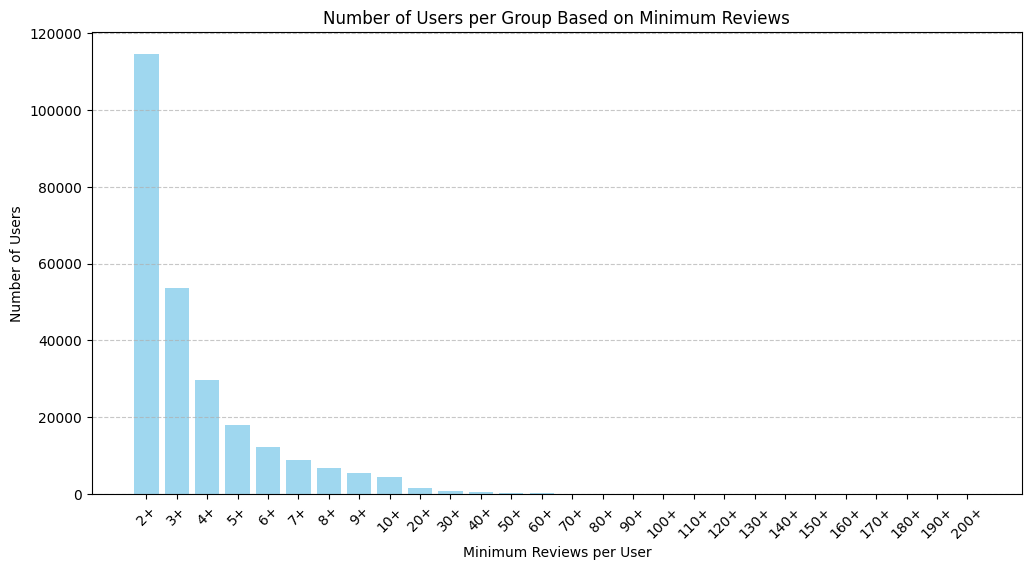

In [20]:
# Step 1: Aggregate reviews by user
user_review_counts = frequent_items_reviews.groupby('author_id')['product_id'].nunique()

# Step 2: Define thresholds for grouping
thresholds = list(range(2, 11)) + [20, 30] + list(range(40, user_review_counts.max() + 10, 10))

# Step 3: Count users per group
users_per_group = []

for t in thresholds:
    count = (user_review_counts >= t).sum()
    users_per_group.append(count)

# Step 4: Display results
print("Users per group:")
for t, count in zip(thresholds, users_per_group):
    print(f"{t}+ reviews: {count} users")

plt.figure(figsize=(12, 6))
plt.bar([str(t) + "+" for t in thresholds], users_per_group, color="skyblue", alpha=0.8)
plt.title("Number of Users per Group Based on Minimum Reviews")
plt.xlabel("Minimum Reviews per User")
plt.ylabel("Number of Users")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Threshold on users with 10+ reviews

In [21]:
# Selecting users with 10+ reviews
filtered_df = frequent_items_reviews.groupby('author_id').filter(lambda x: x['product_id'].nunique() > 9)

# Display the filtered DataFrame
print(f"Number of rows in the filtered dataframe: {len(filtered_df)}")
print(f"Number of unique authors in the filtered dataframe: {len(set(filtered_df['author_id']))}")
#set(filtered_df['author_id'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Number of rows in the filtered dataframe: 93217
Number of unique authors in the filtered dataframe: 4462


In [22]:
# Combining all the products reviewed for each person in the dataset
selected_columns = filtered_df[['author_id', 'product_id']]

# Convert product_id to string before applying 'join'
combined_reviews = selected_columns.groupby('author_id')['product_id'].apply(lambda x: ' '.join(x.astype(str))).reset_index()

print(combined_reviews)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



            author_id                                         product_id
0          1000235057  P420652 P421275 P297524 P456412 P232903 P37584...
1         10003868106  P420652 P480612 P375849 P375853 P472468 P37585...
2          1001087549  P309308 P423688 P270594 P433520 P232915 P45621...
3         10015807972  P420652 P427419 P454380 P480612 P427406 P42741...
4         10021044780  P309308 P442840 P466123 P500633 P418346 P47641...
...               ...                                                ...
4457        998162812  P269122 P429952 P471237 P443833 P422022 P37970...
4458        998179876  P309308 P429952 P270594 P442840 P466123 P44779...
4459        998853649  P456398 P461159 P461933 P456213 P429242 P41561...
4460       9990263118  P430337 P427406 P431180 P440307 P410400 P45567...
4461  orderGen1698648  P443833 P428095 P455926 P502656 P446423 P45536...

[4462 rows x 2 columns]


In [23]:
# Convert the 'reviews' into a list of transactions
transactions = combined_reviews['product_id'].str.split().tolist()

# Create a DataFrame for one-hot encoding
# Flatten all unique items (reviews) and create a unique item list
te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_array, columns=te.columns_)

# Apply the Apriori algorithm
frequent_itemsets = apriori(df_encoded, min_support=0.03, use_colnames=True)

# Focus on frequent itemsets containing only a single product (not pairs or larger sets)
frequent_pairs = frequent_itemsets[frequent_itemsets['itemsets'].apply(len) == 1]

# Generate association rules, with support as minimum of 3%
rules = association_rules(frequent_itemsets, metric="support", min_threshold=0.03, num_itemsets=len(frequent_itemsets))

print(frequent_pairs)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



      support   itemsets
0    0.077095  (P232915)
1    0.052891  (P269122)
2    0.268489  (P270594)
3    0.184895  (P309308)
4    0.039892  (P379707)
..        ...        ...
193  0.048633  (P505049)
194  0.070596  (P505054)
195  0.037203  (P505139)
196  0.032048  (P505158)
197  0.032048    (P7880)

[198 rows x 2 columns]


In [24]:
# Filter rules to include only those where antecedents have a single item
rules_filtered = rules[rules['antecedents'].apply(len) == 1].copy()

rules_display = rules_filtered[["antecedents", "consequents", "support", "confidence", "lift"]].copy()

# Convert frozensets to readable strings
rules_display["antecedents"] = rules_display["antecedents"].apply(lambda x: ', '.join(list(x)))
rules_display["consequents"] = rules_display["consequents"].apply(lambda x: ', '.join(list(x)))

# Sorting by confidence
rules_display = rules_display.sort_values(by="support", ascending=False)
print(rules_display.to_string(index=False))

antecedents               consequents  support  confidence      lift
    P270594                   P500633 0.149260    0.555927  1.945525
    P500633                   P270594 0.149260    0.522353  1.945525
    P503936                   P500633 0.129314    0.594233  2.079582
    P500633                   P503936 0.129314    0.452549  2.079582
    P270594                   P503936 0.124608    0.464107  2.132693
    P503936                   P270594 0.124608    0.572606  2.132693
    P500633                   P476414 0.115867    0.405490  1.851891
    P476414                   P500633 0.115867    0.529171  1.851891
    P476414                   P270594 0.113178    0.516888  1.925172
    P270594                   P476414 0.113178    0.421536  1.925172
    P500633                   P479841 0.107127    0.374902  2.096256
    P479841                   P500633 0.107127    0.598997  2.096256
    P500777                   P500633 0.106455    0.668073  2.337994
    P500633                   P500

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



### Testing

In [25]:
filtered_rules = rules_display[rules_display['antecedents'].apply(lambda x: 'P500633' in x)]
print(filtered_rules)

     antecedents                consequents   support  confidence      lift
104      P500633                    P270594  0.149260    0.522353  1.945525
902      P500633                    P503936  0.129314    0.452549  2.079582
622      P500633                    P476414  0.115867    0.405490  1.851891
752      P500633                    P479841  0.107127    0.374902  2.096256
874      P500633                    P500777  0.106455    0.372549  2.337994
...          ...                        ...       ...         ...       ...
2293     P500633           P503668, P503936  0.030255    0.105882  2.282353
2281     P500633           P503726, P501760  0.030031    0.105098  2.576634
2514     P500633  P270594, P482676, P479841  0.030031    0.105098  2.619818
2374     P500633  P270594, P476414, P423148  0.030031    0.105098  2.494401
802      P500633                    P482061  0.030031    0.105098  2.287549

[208 rows x 5 columns]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [26]:
# Preprocess the rules DataFrame to ensure 'antecedents' and 'consequents' are sets
def preprocess_rules(rules):
   """
   Preprocess the rules DataFrame to ensure 'antecedents' and 'consequents' are sets.
   """
    # Create a copy of the DataFrame to avoid modifying the original
   rules = rules.copy()
   rules['antecedents'] = rules['antecedents'].apply(lambda x: x.split(", ") if isinstance(x, str) else x)
   rules['consequents'] = rules['consequents'].apply(lambda x: x.split(", ") if isinstance(x, str) else x)
   return rules

# Function to find items associated with an input item
def find_associated_items(input_item, rules):
   """
   Find all items associated with an input item based on association rules.

   Parameters:
      input_item (str): The item to find associations for.
      rules (pd.DataFrame): A DataFrame of association rules with columns 'antecedents' and 'consequents'.

   Returns:
      list: A list of items associated with the input item, preserving the order of rules.
   """
   # Sort rules by confidence in descending order
   rules = rules.sort_values(by='confidence', ascending=False).reset_index(drop=True)

   input_item_antecedents = [input_item]

   associated_items = []

   # Iterate through the rules
   for _, rule in rules.iterrows():
      antecedents = rule['antecedents']
      consequents = rule['consequents']

      # Check if the input item is in the antecedents
      if input_item_antecedents == antecedents:
         # Add consequents to the associated items if not already present
         for item in consequents:
               if item not in associated_items:
                  associated_items.append(item)

   return associated_items

rules_df = pd.DataFrame(rules_display)

# Preprocess the rules DataFrame
rules_df = preprocess_rules(rules_df)

# Input item
input_item = 'P500633'

# Find associated items
associated_items = find_associated_items(input_item, rules_df)
print(f"Items associated with '{input_item}': {associated_items}")

Items associated with 'P500633': ['P270594', 'P503936', 'P476414', 'P479841', 'P500777', 'P423688', 'P479327', 'P501760', 'P482676', 'P501254', 'P400259', 'P411365', 'P442840', 'P479318', 'P503726', 'P469538', 'P479645', 'P505031', 'P482535', 'P500288', 'P471237', 'P481739', 'P423148', 'P482551', 'P483076', 'P505023', 'P500857', 'P474832', 'P466123', 'P309308', 'P477157', 'P503668', 'P481831', 'P481989', 'P482540', 'P505009', 'P455236', 'P481732', 'P433520', 'P500993', 'P471046', 'P461949', 'P471043', 'P503814', 'P505054', 'P418624', 'P232915', 'P442838', 'P456218', 'P504045', 'P500744', 'P462666', 'P505024', 'P442839', 'P504044', 'P503651', 'P481830', 'P501288', 'P475124', 'P474075', 'P504125', 'P479348', 'P458219', 'P470529', 'P501282', 'P480461', 'P483679', 'P505049', 'P500618', 'P503891', 'P481366', 'P479692', 'P480613', 'P505020', 'P423136', 'P503879', 'P502326', 'P482061']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [27]:
rules_display.to_csv('processed_data/association_rules.csv', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



____

# 5. Similar Items Based on Ingredients and Highlights

### Calculate similar items using ingredients

To calculate similar items using ingredients we choose to embed ingredients with TF-IDF. This was chosen because TF-IDF will take into account the uniqueness of ingredients. For example water is a frequent ingredient in the list which does not tell us a lot about the product. Where as salicylic acid does not occur as often leading to higher importance. To compute the similarity between products we choose cosine similarity because TF-IDF gives results in the form of embedding.

#### Display ingredients

In [28]:
df = pd.read_csv("processed_data/skincare.csv")
# Select only 'Name' and 'Ingredients' columns
df_selected = df[['product_name', 'ingredients']]

# Display the first 5 rows
print(df_selected.head())

                                        product_name  \
0               GENIUS Sleeping Collagen Moisturizer   
1                       GENIUS Liquid Collagen Serum   
2               GENIUS Liquid Collagen Lip Treatment   
3  SUBLIME DEFENSE Ultra Lightweight UV Defense F...   
4                   GENIUS Ultimate Anti-Aging Cream   

                                         ingredients  
0  Collagen, Water, Ethylhexyl Palmitate, Oryza S...  
1  Collagen, Water, Propanediol, Isononyl Isonona...  
2  Collagen, Water, Glycerin, Isononyl Isononanoa...  
3  Octinoxate 75%, Titanium Dioxide 2%, Zinc Oxid...  
4  Water, Caprylic/Capric Triglyceride, Hydrogena...  


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



#### Define functions

In [29]:
def custom_tokenizer(text):
   return text.split(", ")

def similarity_search_ingredients(df, query):
   """
   Perform a similarity search based on cosine similarity of TF-IDF vectors.

   Parameters:
   - query (str): The input query string.
   - df (pd.DataFrame): A DataFrame containing 'id' and 'ingredients' columns.

   Returns:
   - results_df (pd.DataFrame): Rows from the original DataFrame sorted by similarity.
   """
   # Initialize TfidfVectorizer with a custom tokenizer (adjust lowercase as needed)
   vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, lowercase=False)

   # Extract the 'ingredients' column
   ingredients = df['ingredients']

   # Fit and transform the ingredients
   tfidf_matrix = vectorizer.fit_transform(ingredients)

   # Transform the query into the TF-IDF space
   query_tfidf = vectorizer.transform([query])

   # Compute cosine similarity between the query and all documents
   similarities = cosine_similarity(query_tfidf, tfidf_matrix).flatten()

   # Add similarity scores to the DataFrame
   df['similarity_score_ingredients'] = similarities

   # Sort the DataFrame by similarity scores in descending order
   results_df = df.sort_values(by='similarity_score_ingredients', ascending=False).reset_index(drop=True)

   results_df['rank_ingredients'] = range(1, len(results_df) + 1)

   return results_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



### Calculate similarity using the highlights

In the dataset we choose we were not provided with description but rather highlights of a product. Those are sets of words that describe the product, so therefore there was no need to use the minhashing as the length of sets is not big to begging with. To compare the sets we choose to use Jaccard Similarity because the more highlight product have in common the more similar they are.

#### Display a few rows of highlights

In [30]:
df_selected = df[['product_name', 'highlights']]

# Display the first 5 rows
print(df_selected.head())

                                        product_name  \
0               GENIUS Sleeping Collagen Moisturizer   
1                       GENIUS Liquid Collagen Serum   
2               GENIUS Liquid Collagen Lip Treatment   
3  SUBLIME DEFENSE Ultra Lightweight UV Defense F...   
4                   GENIUS Ultimate Anti-Aging Cream   

                                          highlights  
0  Vegan, Loss of firmness, Collagen, Hypoallerge...  
1  Vegan, Loss of firmness, Collagen, Hypoallerge...  
2  Vegan, Loss of firmness, Plumping, Collagen, H...  
3  Vegan, Hypoallergenic, UV Protection, SPF, Dry...  
4  Vegan, Collagen, Hypoallergenic, Loss of firmn...  


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



#### Define functions

In [31]:
def jaccard_similarity(set_a, set_b):
   """
   Calculate the Jaccard Similarity between two sets.
   """
   intersection = len(set_a.intersection(set_b))
   union = len(set_a.union(set_b))
   return intersection / union if union != 0 else 0.0

def similarity_search_highlights(df, token_list):
   """
   Perform similarity search based on Jaccard similarity between df and a token list.

   :param df: A pandas DataFrame with columns ['product_id','product_name', 'highlights'].
   :param token_list: A list of tokens to compare against (highlights).
   :return: A DataFrame with IDs and their Jaccard similarity scores, sorted by similarity score.
   """
   # Convert the token list to a set
   token_set = set(token_list)

   # List to store the similarity scores
   similarity_scores = []

   # Iterate over the rows of the DataFrame
   for index, row in df.iterrows():
      product_id = row['product_id']
      title = row['product_name']
      # Convert the tokens for this ID to a set
      id_token_set = set(row['highlights'].split(", "))

      # Calculate Jaccard similarity
      similarity_score = jaccard_similarity(id_token_set, token_set)

      # Append the result as a tuple (id, score)
      similarity_scores.append((product_id, title, similarity_score, (row['highlights'])))

   # Convert the list of similarity scores to a DataFrame
   similarity_df = pd.DataFrame(similarity_scores, columns=['product_id', 'product_name', 'similarity_score_highlights', 'highlights'])

   # Sort the DataFrame by the 'similarity_score' column in descending order
   similarity_df_sorted = similarity_df.sort_values(by='similarity_score_highlights', ascending=False).reset_index(drop=True)

   similarity_df_sorted['rank_highlights'] = range(1, len(similarity_df_sorted) + 1)

   return similarity_df_sorted

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



### Combining similarities based on highlight and ingredients
Jaccard similarity measure is in range [0, 1] and cosine similarity is in range [-1, 1] which means that we can not simply calculate the average or weighted sum. Due to that reason we choose to use reciprocal rank fusiona algorithm. To use it we need to rank our similarities tables which is already done in their respective functions.
The **Reciprocal Rank Fusion (RRF)** score for a product _d_ is calculated as:
$$
RRF(d) = \sum_{i=1}^{N} \frac{1}{r_i(d) + k}
\text{}
$$
Where:
- $r_i (d)$ is the rank of product $d$ in the $i^{th}$ ranked list.
- $k$ is a constant (typically $k = 60$), used to prevent division by zero and to adjust the impact of higher ranks.
- $N$ is the number of ranked lists (models or sources).

The reciprocal rank is typically defined as $\frac{1}{r_i(d)}$, where higher ranks give more weight to the document.

In [32]:
def reciprocal_rank_fusion(df_highlights, df_ingredients, k=60):
   """
   Compute Reciprocal Rank Fusion (RRF) scores based on rank_highlights and rank_ingredients.

   Parameters:
   - df_highlights (pd.DataFrame): DataFrame containing 'product_id', 'rank_highlights', and other relevant columns.
   - df_ingredients (pd.DataFrame): DataFrame containing 'product_id', 'rank_ingredients', and other relevant columns.
   - k (int): A constant for RRF computation (default=60).

   Returns:
   - combined_df (pd.DataFrame): A new DataFrame with overall RRF scores and combined ranking.
   """
   # Merge the two DataFrames on 'product_id'
   merged_df = pd.merge(
      df_highlights,  # Include all columns from df_highlights
      df_ingredients[['product_id', 'rank_ingredients']],  # Include only product_id and rank_ingredients
      on='product_id',
      how='inner'
   )

   # Fill missing ranks with a large value (e.g., very low relevance)
   merged_df['rank_highlights'] = merged_df['rank_highlights'].fillna(float('inf'))
   merged_df['rank_ingredients'] = merged_df['rank_ingredients'].fillna(float('inf'))

   # Compute the RRF score
   merged_df['rrf_score'] = (
      1 / (k + merged_df['rank_highlights']) +
      1 / (k + merged_df['rank_ingredients'])
   )

   # Sort by the RRF score in descending order
   merged_df = merged_df.sort_values(by='rrf_score', ascending=False).reset_index(drop=True)

   # Add a new rank based on the RRF score
   merged_df['overall_rank'] = range(1, len(merged_df) + 1)

   return merged_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



### Run code for specific product_id

In [33]:
def get_similar_items(product_id, df, n = 5):
   """
   Retrieve the top N products most similar to a given product based on highlights and ingredients.

   This function takes a product ID, performs similarity searches on the product's highlights and ingredients,
   and combines the results using a reciprocal rank fusion algorithm. It returns the top N most similar products.

   Parameters:
   ----------
   product_id : int or str
      The ID of the product for which similar items are being searched.
   n : int, optional
      The number of similar products to return. Default is 5.

   Returns:
    - merged_results (pd.DataFrame): A new DataFrame containing top n similar items
   """

   # get the selected product
   product = df[df['product_id'] == product_id]

   # get the product highlights and ingredients
   product_highlights =  list(product['highlights'])[0].split(", ")
   product_ingredients = str(product['ingredients'])

   # remove the product I am searching for
   df = df[(df['product_id'] != product_id)]

   # perform similarity searches
   highlights_similarity_results = similarity_search_highlights(df, product_highlights)
   ingredients_similarity_results = similarity_search_ingredients(df, product_ingredients)

   # combine similarity searches with reciprocal rank fusion algorithm
   merged_results = reciprocal_rank_fusion(highlights_similarity_results, ingredients_similarity_results)

   # Return only the top-n products
   return merged_results[:n]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [34]:
df = pd.read_csv("processed_data/skincare.csv")
product_id = "P442001"
product_name = df[df['product_id'] == product_id]['product_name'].iloc[0]
merged = get_similar_items(product_id, df)['product_name'].head(5)

print(f"The most similar products to the {product_name} are: ")
print(merged)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



The most similar products to the Hyaluronic Facial Cream are: 
0                                  Peptide Moisturizer
1    Do Not Age with Dr. Brandt Moisturizing Neck C...
2              Needles No More Wrinkle Smoothing Cream
3                         Eczema+ Dermatitis Face Balm
4                          Youth Junkie Activated Mask
Name: product_name, dtype: object


<ipython-input-29-27cbbccdb254>:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



_____

# 6.Recommender

To handle cases where a product lacks association rules—such as newly introduced items—the system calculates
similarity scores against all other products in the database. It identifies the most similar product and
utilizes its association rules to generate recommendations. This approach maintains consistency in the type
of recommendations provided. Similarly, if there are insufficient association rules, the system leverages the
"similar items" method by using related products as a basis to ensure a consistent and diverse output.

In [35]:
# Recommender function
def recommender(product_id, rules, df, n=5):
    """
    Recommend products based on association rules and similarity.

    Parameters:
        product_id (str): The product ID for which recommendations are needed.
        rules (pd.DataFrame): A DataFrame of association rules with columns 'antecedents' and 'consequents'.
        n (int): Number of recommendations to return.

    Returns:
        list: Recommended products.
    """

    # Step 1: Find associated items
    associated_items = find_associated_items(product_id, rules)

    # no rule for chosen item
    if len(associated_items) == 0:
        # find the most similar antecedents to the product_id

        # get all the single antecedents in the rules
        antecedents = [
            list(item)[0]
            for item in rules["antecedents"]
            if len(item) == 1
        ]

        # filter skincare so it searches for the similar items only among the antecedents and product_id
        antecedents.append(product_id)
        df_antecedents = df[df['product_id'].isin(antecedents)]

        # the most similar antecedents to a product_id
        the_most_similar_product_id = get_similar_items(product_id, df_antecedents, n = 1)['product_id'].iloc[0]

        associated_items = find_associated_items(the_most_similar_product_id, rules)

    # get the top n associated items
    if len(associated_items) >= n:
        return associated_items[:n]

    # if there are not enough  associated items get the similar items to the product_id as well
    else:
        number_of_similar_items = n - len(associated_items)

        # for each of the consequents find similar items and combine them in one dataframe
        similar_items_dataframes = []
        for i in associated_items:
            # get the top number_of_similar_items
            similar_items = get_similar_items(product_id, df)
            similar_items_dataframes.append(similar_items)

        all_similar_items = pd.concat(similar_items_dataframes, axis=0)

        # order is by similarity_score_highlights
        all_similar_items = all_similar_items.sort_values(by='rrf_score', ascending=False).reset_index(drop=True)

        # take only the top number_of_similar_items
        similar_products = list(all_similar_items['product_id'])[:number_of_similar_items]

        return associated_items + similar_products

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



### Load data

In [36]:
association_rules = pd.read_csv('processed_data/association_rules.csv')
association_rules = preprocess_rules(association_rules)
skincare_df = pd.read_csv("processed_data/skincare.csv")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



### Example of usage

In [37]:
random_product_id = skincare_df['product_id'].sample(n=1).iloc[0]

product_name = skincare_df[skincare_df['product_id'] == random_product_id]['product_name'].iloc[0]
merged = get_similar_items(random_product_id, skincare_df)['product_name'].head(5)

print(f"The most similar products to the {product_name} are: ")
print(merged)

The most similar products to the Sun Drops SPF 50 are: 
0    Daily Dose Hydra-Ceramide Boost + SPF 40 Sunsc...
1              Refreshing Water Sunscreen Stick SPF 50
2       PLAY Mineral Mist SPF 30 with Marigold Extract
3                           Targeted Wrinkle Corrector
4                      Sex Dust   Adaptogens For Fire*
Name: product_name, dtype: object


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

<ipython-input-29-27cbbccdb254>:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

